### Student Information
Name: 詹睿軒

Student ID: 113062543

GitHub ID: Big-problem

---

### Instructions

1. First: do the **take home** exercises in the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://huggingface.co/datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data). The dataset contains a `sentiment` and `comment` columns, with the sentiment labels being: 'nostalgia' and 'not nostalgia'. Read the specificiations of the dataset for background details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/didiersalazar/DM2024-Lab1-Master/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 27th 11:59 pm, Sunday)__. 

# First Part

In [73]:
### Begin Assignment Here

import math

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score

import umap.umap_ as umap

import helpers.data_mining_helpers as dmh

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk

from PAMI.extras.DF2DB import DenseFormatDF as db
from PAMI.extras.dbStats import TransactionalDatabase as tds
from PAMI.frequentPattern.basic import FPGrowth as alg
from PAMI.frequentPattern.maximal import MaxFPGrowth as max_alg
from PAMI.frequentPattern.topk import FAE as top_alg



In [4]:
# categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42) 
#This command also shuffles the data randomly, but with random_state we can bring the same distribution of data everytime 
#if we choose the same number, in this case "42". This is good for us, it means we can reproduce the same results every time
#we want to run the code.

In [5]:
# construct dataframe from a list
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])

# add category to the dataframe
X['category'] = twenty_train.target

# add category label also
X['category_name'] = X.category.apply(lambda t: twenty_train.target_names[t])

---

### **>>> Exercise 2 (take home):** 
Experiment with other querying techniques using pandas dataframes. Refer to their [documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html) for more information. 

In [7]:
#Answer here
# Access only one value can use at and iat
print(X.at[3, 'category_name']) # by label

print(X.iat[3, 2]) # by index

soc.religion.christian
soc.religion.christian


---

### >>> **Exercise 5 (take home)** 
There is an old saying that goes, "The devil is in the details." When we are working with extremely large data, it's difficult to check records one by one (as we have been doing so far). And also, we don't even know what kind of missing values we are facing. Thus, "debugging" skills get sharper as we spend more time solving bugs. Let's focus on a different method to check for missing values and the kinds of missing values you may encounter. It's not easy to check for missing values as you will find out in a minute.

Please check the data and the process below, describe what you observe and why it happened.   
$Hint$ :  why `.isnull()` didn't work?

In [8]:
NA_dict = [{ 'id': 'A', 'missing_example': np.nan },
           { 'id': 'B'                    },
           { 'id': 'C', 'missing_example': 'NaN'  },
           { 'id': 'D', 'missing_example': 'None' },
           { 'id': 'E', 'missing_example':  None  },
           { 'id': 'F', 'missing_example': ''     }]

NA_df = pd.DataFrame(NA_dict, columns = ['id','missing_example'])
NA_df

id missing_example
0  A             NaN
1  B             NaN
2  C             NaN
3  D            None
4  E            None
5  F

In [10]:
NA_df['missing_example'].isnull()

0     True
1     True
2    False
3    False
4     True
5    False
Name: missing_example, dtype: bool

In [11]:
# Answer here
# For {'NaN', 'None', ''}, python consider them as strings, so the  results are False
# As for {np.nan, , None}, they are considered as missing value, so the results are True

---

### >>> Exercise 6 (take home):
Notice any changes from the `X` dataframe to the `X_sample` dataframe? What are they? Report every change you noticed as compared to the previous state of `X`. Feel free to query and look more closely at the dataframe for these changes.

In [12]:
X_sample = X.sample(n=1000) #random state

X_sample

text  category  \
1211  From: paulson@tab00.larc.nasa.gov (Sharon Paul...         2   
1037  From: mcovingt@aisun3.ai.uga.edu (Michael Covi...         3   
817   From: rind@enterprise.bih.harvard.edu (David R...         2   
2179  From: ednclark@kraken.itc.gu.edu.au (Jeffrey C...         0   
1538  From: morgan@socs.uts.edu.au Subject: re: tech...         3   
...                                                 ...       ...   
1054  From: aa888@freenet.carleton.ca (Mark Baker) S...         3   
787   From: Deon.Strydom@f7.n7104.z5.fidonet.org (De...         3   
2059  From: ederveen@athena.research.ptt.nl (Edervee...         1   
906   From: SITUNAYA@IBM3090.BHAM.AC.UK Subject: tes...         1   
996   From: parkin@Eng.Sun.COM (Michael Parkin) Subj...         3   

               category_name  
1211                 sci.med  
1037  soc.religion.christian  
817                  sci.med  
2179             alt.atheism  
1538  soc.religion.christian  
...                      ...  
1054  soc.religion.christian  
787   soc.religion.christian  
2059           comp.graphics  
906            comp.graphics  
996   soc.religion.christian  

[1000 rows x 3 columns]

In [13]:
# Answer here
# After X.sample(n=1000), we will randomly get 1000 records of X. The results are random and shuffled. The index stays the same and doesn't re-index from 0 to 999

---

### >>> **Exercise 8 (take home):** 
We can also do a side-by-side comparison of the distribution between the two datasets, but maybe you can try that as an excerise. Below we show you an snapshot of the type of chart we are looking for. 

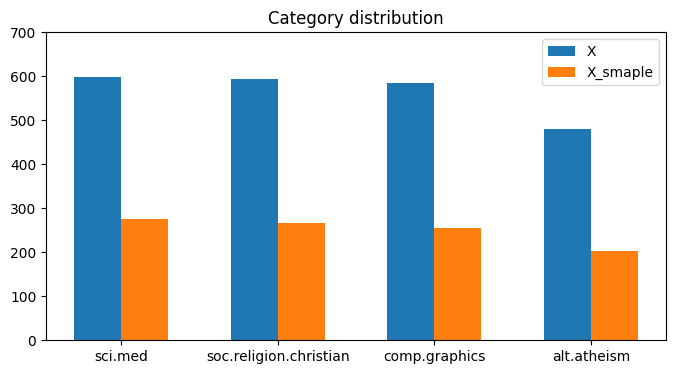

In [14]:
l1, l2, l3 = [0,1,2,3], [0.3,1.3,2.3,3.3], [0.15,1.15,2.15,3.15]
categories.sort(key = lambda x : X_sample.category_name.value_counts()[x], reverse=True)

plt.figure(figsize=(8, 4))
plt.bar(l1, X.category_name.value_counts(), 0.3, label = 'X')
plt.bar(l2, X_sample.category_name.value_counts(), 0.3, label = 'X_smaple')

plt.title('Category distribution')
plt.xticks(ticks=l3, labels=categories, rotation=0, ha='center')
plt.ylim(0, 700)
plt.legend()

plt.show()

---

In [15]:
# takes a minute or two to process
X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

In [16]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(X_counts[0])

  (np.int32(0), np.int32(14887))	1
  (np.int32(0), np.int32(29022))	1
  (np.int32(0), np.int32(8696))	4
  (np.int32(0), np.int32(4017))	2
  (np.int32(0), np.int32(33256))	2
  (np.int32(0), np.int32(21661))	3
  (np.int32(0), np.int32(9031))	3
  (np.int32(0), np.int32(31077))	1
  (np.int32(0), np.int32(9805))	2
  (np.int32(0), np.int32(17366))	1
  (np.int32(0), np.int32(32493))	4
  (np.int32(0), np.int32(16916))	2
  (np.int32(0), np.int32(19780))	2
  (np.int32(0), np.int32(17302))	2
  (np.int32(0), np.int32(23122))	1
  (np.int32(0), np.int32(25663))	1
  (np.int32(0), np.int32(16881))	1
  (np.int32(0), np.int32(16082))	1
  (np.int32(0), np.int32(23915))	1
  (np.int32(0), np.int32(32142))	5
  (np.int32(0), np.int32(33597))	2
  (np.int32(0), np.int32(20253))	1
  (np.int32(0), np.int32(587))	1
  (np.int32(0), np.int32(12051))	1
  (np.int32(0), np.int32(5201))	1
  :	:
  (np.int32(0), np.int32(25361))	1
  (np.int32(0), np.int32(25337))	1
  (np.int32(0), np.int32(12833))	2
  (np.int32(0), np.in

---

### **>>> Exercise 10 (take home):**
We said that the `1` at the beginning of the fifth record represents the `00` term. Notice that there is another 1 in the same record. Can you provide code that can verify what word this 1 represents from the vocabulary. Try to do this as efficient as possible.

In [17]:
# Answer here
count_vect.get_feature_names_out()[37]

'01'

---

### **>>> Exercise 11 (take home):** 
From the chart above, we can see how sparse the term-document matrix is; i.e., there is only one terms with **FREQUENCY** of `1` in the subselection of the matrix. By the way, you may have noticed that we only selected 20 articles and 20 terms to plot the histrogram. As an excersise you can try to modify the code above to plot the entire term-document matrix or just a sample of it. How would you do this efficiently? Remember there is a lot of words in the vocab. Report below what methods you would use to get a nice and useful visualization

In [ ]:
# My approach:
# I still choose first 20 documents in this heatmap. As for the terms, i make sure that every column should have at least one non-zero terms.
# I scan from the beginning and pick the first 20 terms that satisfy this requierement

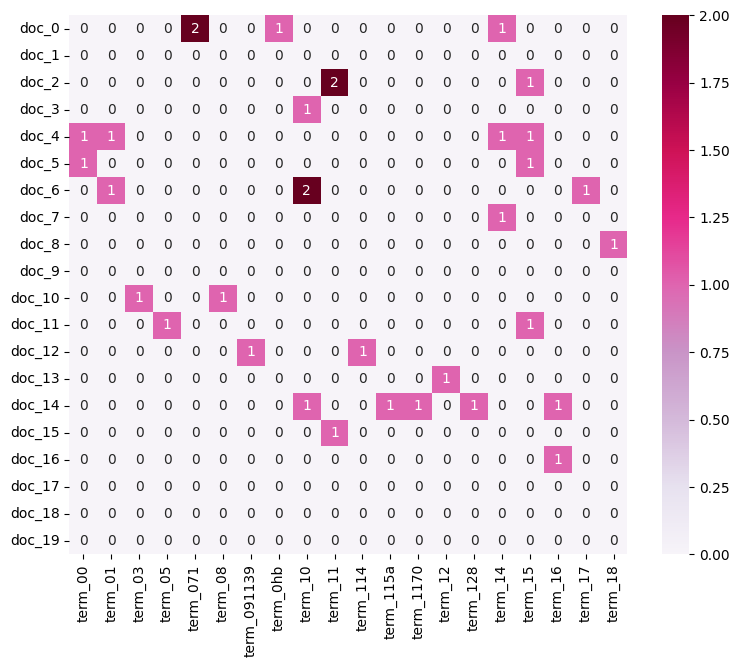

In [18]:
# Answer here

total = 0
arr = X_counts[0:20, 0:].toarray()
plot_x, plot_z = [], []
for i in range(20):
    tmp = []
    for i in range(20):
        tmp.append(-1)
    plot_z.append(tmp)

plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
for i in range(X_counts.shape[1]):
    flag = 0
    for j in range(20):
        plot_z[j][total] = arr[j][i]
        if arr[j][i] != 0:
            flag = 1

    if flag:
        total += 1
        plot_x.append("term_"+str(count_vect.get_feature_names_out()[i]))
        if total == 20:
            break

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=2, annot=True)

---

### >>> **Exercise 12 (take home):**
If you want a nicer interactive visualization here, I would encourage you try to install and use plotly to achieve this.

In [19]:
l = np.asarray(X_counts[:, :300].sum(axis=0))[0]
x = [i for i in count_vect.get_feature_names_out()[:300]]
df = pd.DataFrame({'Term': x,
                   'Term Freauency': l})

In [20]:
fig = px.bar(df, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title='Term Freauency'
            )
fig.update_layout(font_size=11)
fig.show()

---

### >>> **Exercise 13 (take home):** 
The chart above only contains 300 vocabulary in the documents, and it's already computationally intensive to both compute and visualize. Can you efficiently reduce the number of terms you want to visualize as an exercise. 


In [21]:
# I select 100 terms which appear more than 20 times
l = np.asarray(X_counts[:, :].sum(axis=0))[0]
x, y = [], []
total = 0
for i in range(len(l)):
    if l[i] >= 20:
        x.append(count_vect.get_feature_names_out()[i])
        y.append(l[i])
        total += 1
    if total > 100:
        break
df = pd.DataFrame({'Term': x,
                   'Term Freauency': y})

In [22]:
fig = px.bar(df, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' 100 Terms occurrence more than 20 times'
            )
fig.update_layout(font_size=11)
fig.show()

---

### >>> **Exercise 14 (take home):** 
Additionally, you can attempt to sort the terms on the `x-axis` by frequency instead of in alphabetical order. This way the visualization is more meaninfgul and you will be able to observe the so called [long tail](https://en.wikipedia.org/wiki/Long_tail) (get familiar with this term since it will appear a lot in data mining and other statistics courses). see picture below

In [23]:
# i select the top 300 most frequent terms
x = [i for i in count_vect.get_feature_names_out()]
y, x = zip(*sorted(zip(l, x)))
y = list(reversed(y))
x = list(reversed(x))
df = pd.DataFrame({'Term': x[:300], 'Term Freauency': y[:300]})
fig = px.bar(df, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' Top 300 most frequent terms'
            )
fig.update_layout(font_size=11)
fig.show()

---

### >>> **Exercise 15 (take home):** 
You can copy the code from the previous exercise and change the 'term_frequencies' variable for the 'term_frequencies_log', comment about the differences that you observe and talk about other possible insights that we can get from a log distribution.

In [24]:
# i select the top 2000 most frequent terms and apply log transformation
x = [i for i in count_vect.get_feature_names_out()]
y, x = zip(*sorted(zip(l, x)))
y = list(reversed(y))
x = list(reversed(x))
y = [math.log(i) for i in y]
df = pd.DataFrame({'Term': x[:2000], 'Term Freauency': y[:2000]})
fig = px.bar(df, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' Top 2000 most frequent terms'
            )
fig.update_layout(font_size=11)
fig.show()

In [ ]:
# After apply the log transformation, we can see that the difference between each result is smaller. The maximum frequency is only 10 instead of 30000.
# Since the frequencies are closer to each other, maybe we can first assume that all the terms that the frequency between 5~6 are consider important,
# and then do more experienment to verify it or overthrow it

-------------

### >>> **Exercise 16 (take home):** 
Review the words that were filtered in each category and comment about the differences and similarities that you can see.

In [25]:
# Answer here:
# For the top 5% most frequent terms, there is a lot of similarity such as 'the', 'and', 'that'. Although these words indeed cannot tell as much what the article is about , there are still some
# frequent words that i think is vital to the article. For instance, in category 'soc.religion.christian', there are terms like 'jesus', 'church', whick i think are closely related to the category.
# As for the least 1% terms, they are mostly just number. I think that it is fine to just discard these terms.

---

### >>> **Exercise 17 (take home):** 
Implement the FAE Top-K and MaxFPGrowth algorithms from the PAMI library to analyze the 'comp.graphics' category in our processed database. **Only implement the mining part of the algorithm and display the resulting patterns**, like we did with the FPGrowth algorithm after creating the new databases. For the FAE Top-K, run trials with k values of 500, 1000, and 1500, recording the runtime for each. For MaxFPGrowth, test minimum support thresholds of 3, 6, and 9, noting the runtime for these settings as well. Compare the patterns these algorithms extract with those from the previously implemented FPGrowth algorithm. Document your findings, focusing on differences and similarities in the outputs and performance.

In [26]:
topk, maxFPG = [], []
obj = top_alg.FAE(iFile='td_freq_db_comp_graphics.csv', k=500)
obj.mine()
frequentPatterns1 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = top_alg.FAE(iFile='td_freq_db_comp_graphics.csv', k=1000)
obj.mine()
frequentPatterns2 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = top_alg.FAE(iFile='td_freq_db_comp_graphics.csv', k=1500)
obj.mine()
frequentPatterns3 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=3)
obj.mine()
frequentPatterns4 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=6)
obj.mine()
frequentPatterns5 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=9)
obj.mine()
frequentPatterns6 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

print('FAE Top-k:')
print('k = 500:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns1)))
print('  ' + 'Runtime: ' + str(topk[0]))
print('k = 1000:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns2)))
print('  ' + 'Runtime: ' + str(topk[1]))
print('k = 1500:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns3)))
print('  ' + 'Runtime: ' + str(topk[2]))
print('MaxFPGrowth:')
print('minSup = 3:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns4)))
print('  ' + 'Runtime: ' + str(maxFPG[0]))
print('minSup = 6:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns5)))
print('  ' + 'Runtime: ' + str(maxFPG[1]))
print('minSup = 9:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns6)))
print('  ' + 'Runtime: ' + str(maxFPG[2]))

 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
FAE Top-k:
k = 500:
  Total No of patterns: 500
  Runtime: 0.9344496726989746
k = 1000:
  Total No of patterns: 1000
  Runtime: 2.006500482559204
k = 1500:
  Total No of patterns: 1500
  Runtime: 4.238509893417358
MaxFPGrowth:
minSup = 3:
  Total No of patterns: 6872
  Runtime: 22.688091278076172
minSup = 6:
  Total No of patterns: 1340
  Runtime: 0.3967118263244629
minSup = 9:
  Total No of patterns: 660
  Runtime: 0.1111307144165039


Similarity: The higher the thershold is, less number of patterns, so the runtime is shorter


Under the same minSup, MaxFPGrowth finds a lot less number of patterns than FPGrowth does

The output of FAE top-k is sorted from larger support to lower support, while maxFPGrowth is the opposite

In general, the longer the patterns, the lower the support is

---

In [34]:
minSup=9
obj1 = alg.FPGrowth(iFile='td_freq_db_sci_med.csv', minSup=minSup)
obj1.mine()
frequentPatternsDF_sci_med= obj1.getPatternsAsDataFrame()

obj2 = alg.FPGrowth(iFile='td_freq_db_alt_atheism.csv', minSup=minSup)
obj2.mine()
frequentPatternsDF_alt_atheism= obj2.getPatternsAsDataFrame()

obj3 = alg.FPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=minSup)
obj3.mine()
frequentPatternsDF_comp_graphics= obj3.getPatternsAsDataFrame()

obj4 = alg.FPGrowth(iFile='td_freq_db_soc_religion_christian.csv', minSup=minSup)
obj4.mine()
frequentPatternsDF_soc_religion_christian= obj4.getPatternsAsDataFrame()

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm


In [ ]:
#We group together all of the dataframes related to our found patterns
dfs = [frequentPatternsDF_sci_med, frequentPatternsDF_soc_religion_christian, frequentPatternsDF_comp_graphics, frequentPatternsDF_alt_atheism]


# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(df) for df in dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")

In [36]:
# Convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(X['text'])  # X['text'] contains your text data
terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
X['tokenized_text'] = X['text'].str.split().apply(set)

# Initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)

# Concatenate the original TDM and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df

00  000  0000  0000001200  000005102000  0001  000100255pixel  00014  \
0      0    0     0           0             0     0               0      0   
1      0    0     0           0             0     0               0      0   
2      0    0     0           0             0     0               0      0   
3      0    0     0           0             0     0               0      0   
4      1    0     0           0             0     0               0      0   
...   ..  ...   ...         ...           ...   ...             ...    ...   
2252   0    0     0           0             0     0               0      1   
2253   0    0     0           0             0     0               0      0   
2254   0    0     0           0             0     0               0      0   
2255   0    0     0           0             0     0               0      0   
2256   0    0     0           0             0     0               0      0   

      000406  0007  ...  means communications 192 international  brave  \
0          0     0  ...                                       0      0   
1          0     0  ...                                       0      0   
2          0     0  ...                                       0      0   
3          0     0  ...                                       0      0   
4          0     0  ...                                       0      0   
...      ...   ...  ...                                     ...    ...   
2252       0     0  ...                                       0      0   
2253       0     0  ...                                       0      0   
2254       0     0  ...                                       0      0   
2255       0     0  ...                                       0      0   
2256       0     0  ...                                       0      0   

      transplant  unlikely  deeply  holland  pl8 newsreader  pl8 tin  \
0              0         0       0        0               0        0   
1              0         0       0        0               0        0   
2              0         0       0        0               0        0   
3              0         0       0        0               0        0   
4              0         0       0        0               0        0   
...          ...       ...     ...      ...             ...      ...   
2252           0         0       0        0               0        0   
2253           1         0       0        0               0        0   
2254           0         0       0        0               0        0   
2255           0         0       0        0               0        0   
2256           0         0       0        0               0        0   

      newsreader pl8 tin  quackery  
0                      0         0  
1                      0         0  
2                      0         0  
3                      0         0  
4                      0         0  
...                  ...       ...  
2252                   0         0  
2253                   0         0  
2254                   0         0  
2255                   0         0  
2256                   0         0  

[2257 rows x 92947 columns]

In [38]:
X_pca_aug = PCA(n_components=3).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=3).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=3).fit_transform(augmented_df.values)

---

### >>> Exercise 18 (take home):
Please try to reduce the dimension to 3, and plot the result use 3-D plot. Use at least 3 different angle (camera position) to check your result and describe what you found.

$Hint$: you can refer to Axes3D in the documentation.

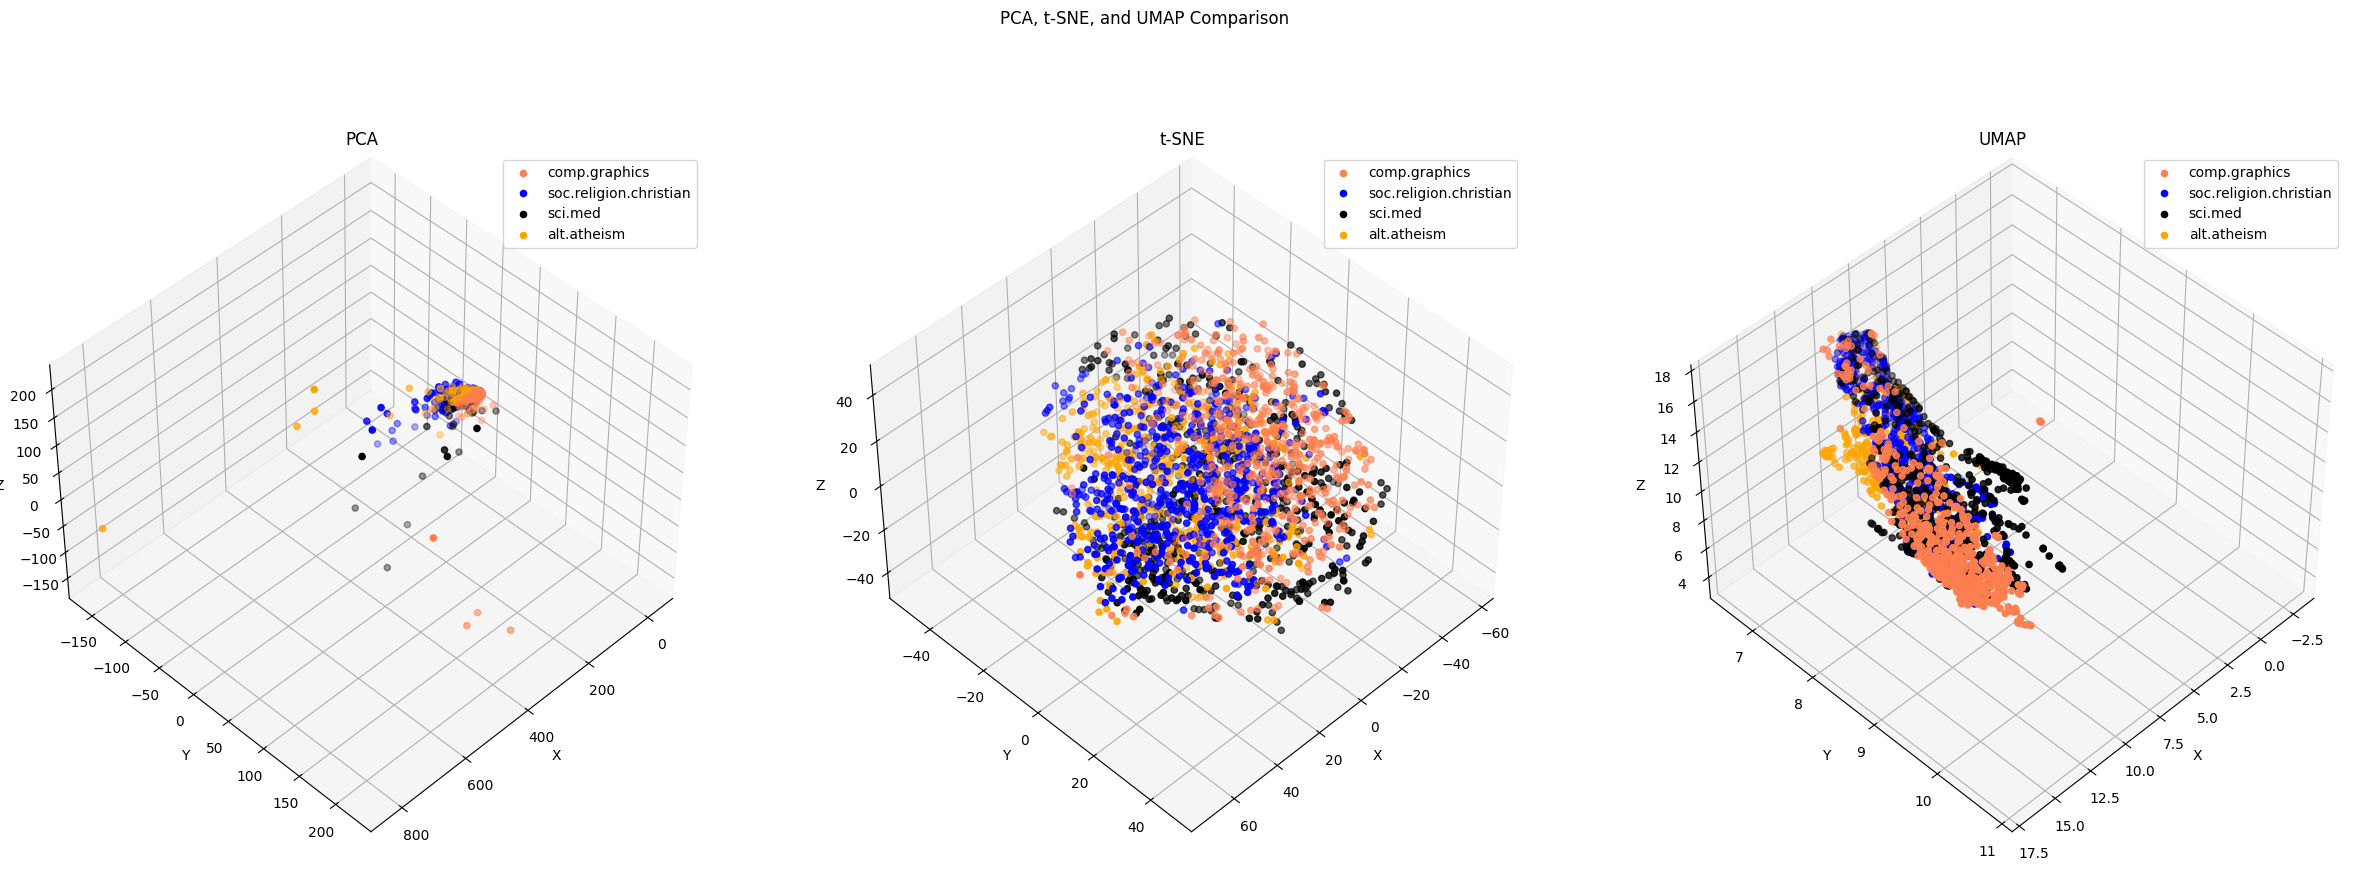

In [40]:
# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title, elev, azim):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        zs = X_reduced[X['category_name'] == category].T[2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')

    ax.view_init(elev=elev, azim=-azim)

# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 

fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')


# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(ax1, X_pca_aug, 'PCA', 45, -45)
plot_scatter(ax2, X_tsne_aug, 't-SNE', 45, -45)
plot_scatter(ax3, X_umap_aug, 'UMAP', 45, -45)



plt.show()

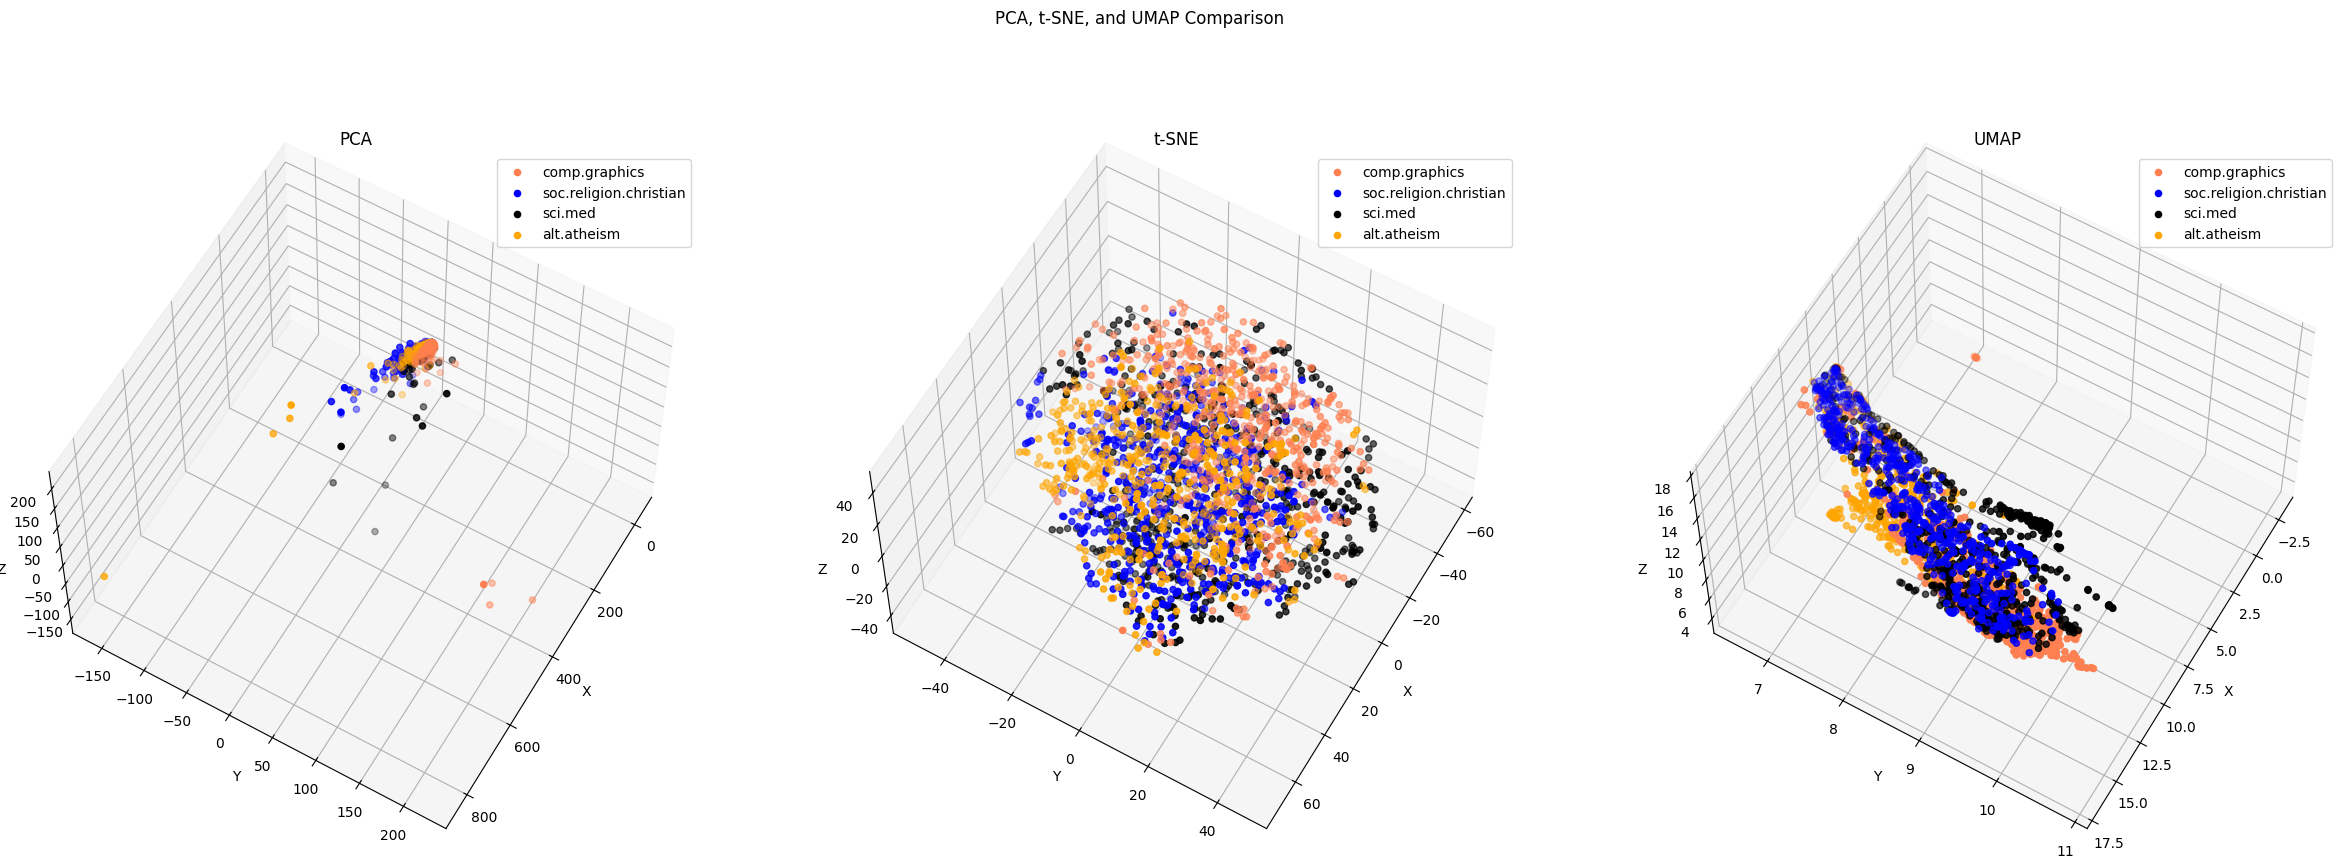

In [41]:
fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax4 = fig.add_subplot(131, projection='3d')
ax5 = fig.add_subplot(132, projection='3d')
ax6 = fig.add_subplot(133, projection='3d')
plot_scatter(ax4, X_pca_aug, 'PCA', 60, -30)
plot_scatter(ax5, X_tsne_aug, 't-SNE', 60, -30)
plot_scatter(ax6, X_umap_aug, 'UMAP', 60, -30)
plt.show()

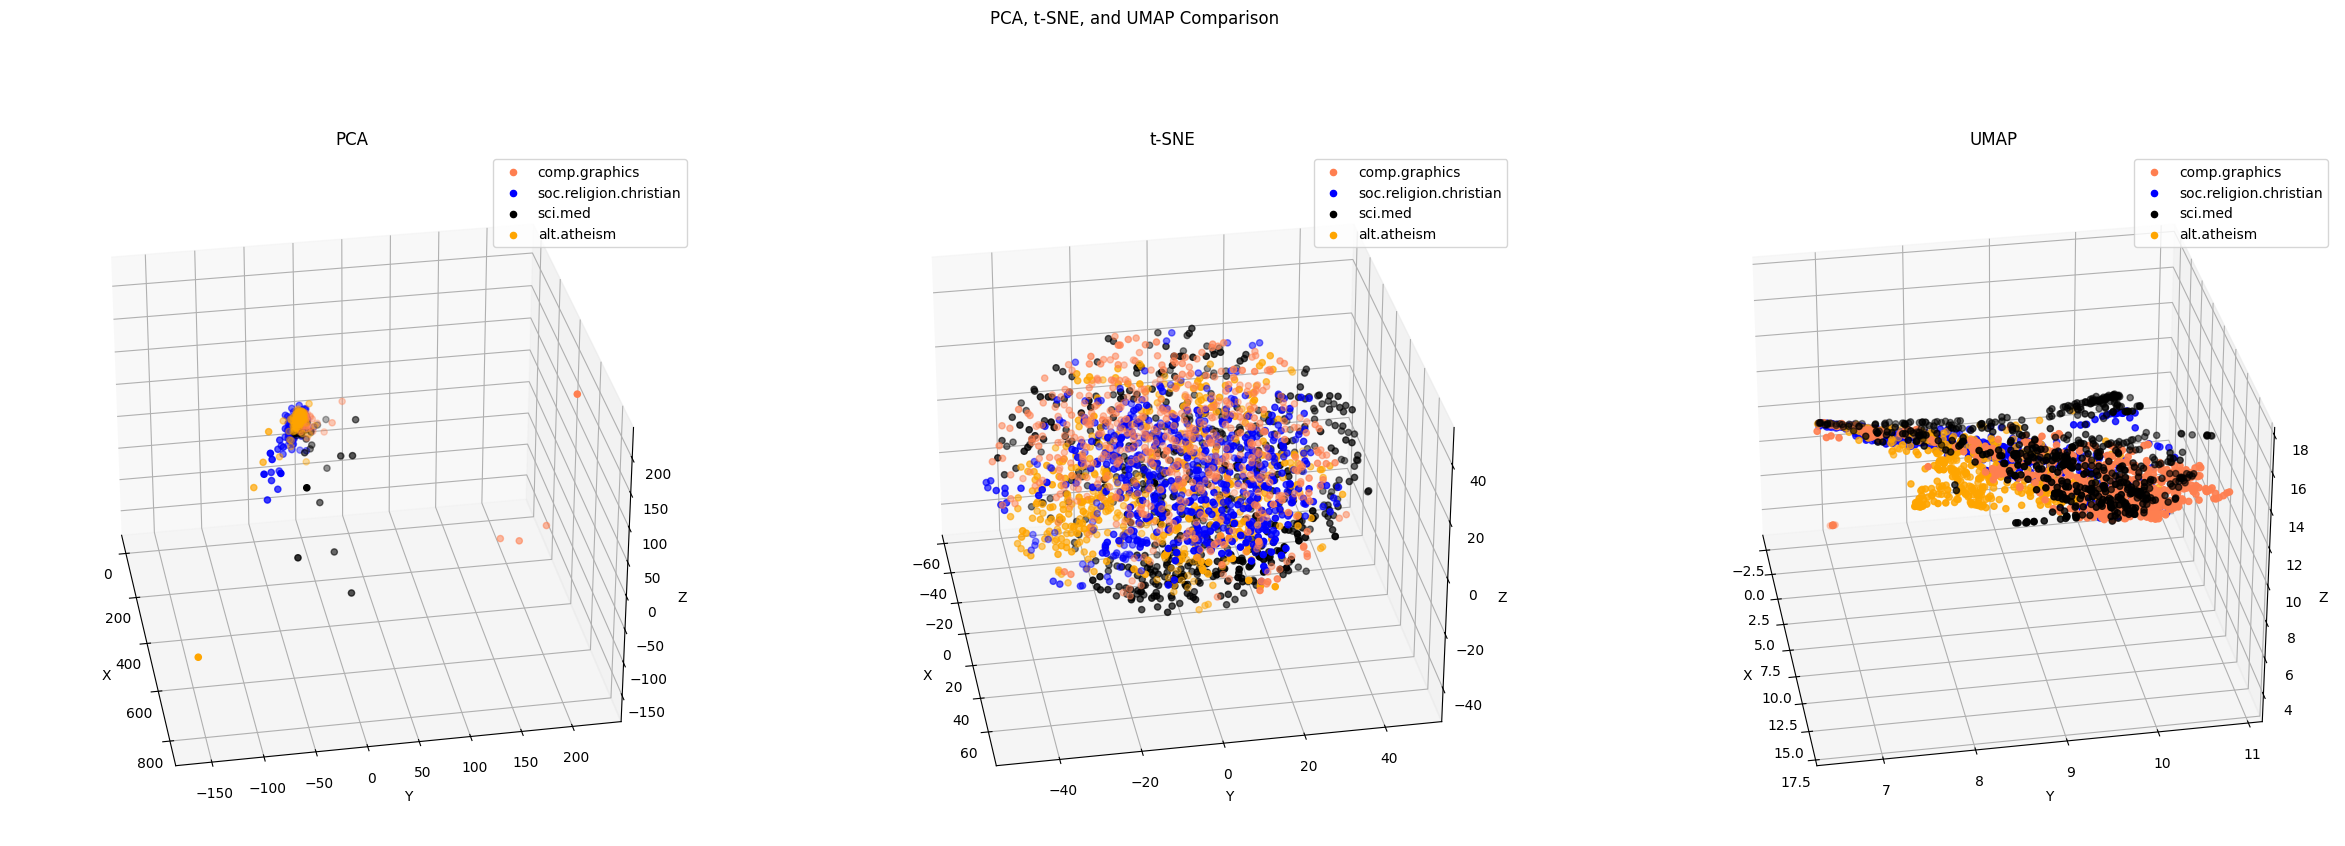

In [42]:
fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax7 = fig.add_subplot(131, projection='3d')
ax8 = fig.add_subplot(132, projection='3d')
ax9 = fig.add_subplot(133, projection='3d')
plot_scatter(ax7, X_pca_aug, 'PCA', 30, 10)
plot_scatter(ax8, X_tsne_aug, 't-SNE', 30, 10)
plot_scatter(ax9, X_umap_aug, 'UMAP', 30, 10)
plt.show()

In [ ]:
# Observation:
# The result of PCA is still stick together. 
# It looks like the result of UMAP is the best because different color doesn't stick to each other
# For example, from the second angle, blue dots are close to the top. From the third angle, yellow dots are close to the moniter

---

### >>> **Exercise 19 (take home):**
Try to generate the binarization using the `category_name` column instead. Does it work?

In [50]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(X.category_name)
X['bin_category_name'] = mlb.transform(X['category_name']).tolist()
X[:8]

# Yes, it works.

text  category  \
0  From: sd345@city.ac.uk (Michael Collier) Subje...         1   
1  From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...         1   
2  From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...         3   
3  From: s0612596@let.rug.nl (M.M. Zwart) Subject...         3   
4  From: stanly@grok11.columbiasc.ncr.com (stanly...         3   
5  From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...         3   
6  From: jodfishe@silver.ucs.indiana.edu (joseph ...         3   
7  From: aldridge@netcom.com (Jacquelin Aldridge)...         2   

            category_name                                           unigrams  \
0           comp.graphics  [From, :, sd345, @, city.ac.uk, (, Michael, Co...   
1           comp.graphics  [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....   
2  soc.religion.christian  [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...   
3  soc.religion.christian  [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...   
4  soc.religion.christian  [From, :, stanly, @, grok11.columbiasc.ncr.com...   
5  soc.religion.christian  [From, :, vbv, @, lor.eeap.cwru.edu, (, Virgil...   
6  soc.religion.christian  [From, :, jodfishe, @, silver.ucs.indiana.edu,...   
7                 sci.med  [From, :, aldridge, @, netcom.com, (, Jacqueli...   

                                      tokenized_text bin_category_name  
0  {Please, anyone, know, this, files, would, adv...      [0, 1, 0, 0]  
1  {For, uv, output, or, some, 3d, it, cells, kno...      [0, 1, 0, 0]  
2  {what, realize, companies, inconceivable, than...      [0, 0, 0, 1]  
3  {german, french)., after, Poland, catholic, bo...      [0, 0, 0, 1]  
4  {"The, man,, 15, <Apr.7.01.56.56.1993.22824@at...      [0, 0, 0, 1]  
5  {foce, conscientious, Jewish, or, genuine, Hay...      [0, 0, 0, 1]  
6  {(joseph, from, Colossians, or, be., self-cont...      [0, 0, 0, 1]  
7  {(408, skin, some, neighbour's, (Pat, know, (J...      [0, 0, 1, 0]

----

# Second Part

In [135]:
# Read the dataset
df = pd.read_csv('Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv')
df.head()

sentiment                                            comment
0  not nostalgia  He was a singer with a golden voice that I lov...
1      nostalgia  The mist beautiful voice ever I listened to hi...
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4      nostalgia  listening to his songs reminds me of my mum wh...

In [136]:
# add category label
df['sentiment_num'] = df.sentiment.apply(lambda x : 1 if x == 'nostalgia' else 0)
df.head()

sentiment                                            comment  \
0  not nostalgia  He was a singer with a golden voice that I lov...   
1      nostalgia  The mist beautiful voice ever I listened to hi...   
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...   
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...   
4      nostalgia  listening to his songs reminds me of my mum wh...   

   sentiment_num  
0              0  
1              1  
2              1  
3              0  
4              1

Experiment with other querying techniques using pandas dataframes. Refer to their [documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html) for more information. 

In [137]:
# Access only one value can use at and iat
print(df.at[3, 'sentiment']) # by label

print(df.iat[3, 1]) # by index (comment)

not nostalgia
30 day leave from 1st tour in Viet Nam to convince my Mary Lou to "marry me" when I came back from my 2nd tour.  Now, 47 years later this December God granted the greatest blessing a man can receive.  This song is for the hope of life all who have served pray for and some are granted that hope to be reality. Thank you my Mary Lou.


In [138]:
#Check missing value
df.isnull().apply(lambda x: dmh.check_missing_values(x), axis=0)

sentiment                             comment  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                        sentiment_num  
0  The amoung of missing records is:   
1                                   0

In [139]:
# add missing value
dummy_series = pd.Series(["dummy_record", 1], index=["comment", "sentiment_num"])
df_missing = pd.concat([df, dummy_series.to_frame().T], ignore_index=True)
df_missing.isnull().apply(lambda x: dmh.check_missing_values(x), axis=0)

sentiment                             comment  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   1                                   0   

                        sentiment_num  
0  The amoung of missing records is:   
1                                   0

In [140]:
# check duplicated data
print('Original length:', len(df))
print('Sum of duplicated data:', sum(df.duplicated()))
df.drop_duplicates(inplace=True) # inplace applies changes directly on our dataframe
print('Length after drop duplicate:', len(df))
print('Sum of duplicated data:', sum(df.duplicated()))

Original length: 1500
Sum of duplicated data: 1
Length after drop duplicate: 1499
Sum of duplicated data: 0


In [141]:
df_sample = df.sample(n=500) #random state
df.sentiment.value_counts()

sentiment
nostalgia        750
not nostalgia    749
Name: count, dtype: int64

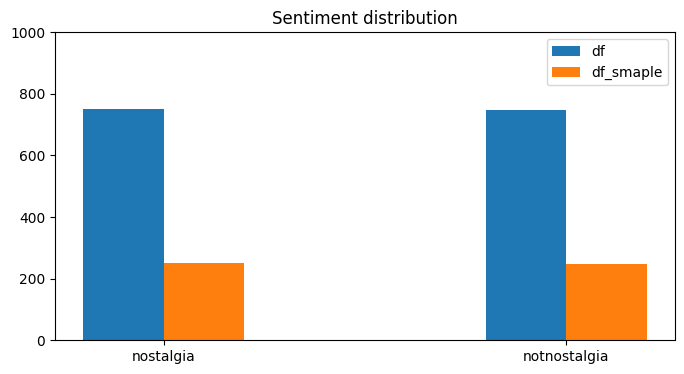

In [142]:
# get smaple data
df_sample = df.sample(n=500) #random state

l1, l2, l3 = [0,1], [0.2,1.2], [0.1,1.1]

plt.figure(figsize=(8, 4))
plt.bar(l1, df.sentiment.value_counts(), 0.2, label = 'df')
plt.bar(l2, df_sample.sentiment.value_counts(), 0.2, label = 'df_smaple')

plt.title('Sentiment distribution')
plt.xticks(ticks=l3, labels=['nostalgia', 'notnostalgia'], rotation=0, ha='center')
plt.ylim(0, 1000)
plt.legend()

plt.show()

In [143]:
# takes a like a minute or two to process
df['unigrams'] = df['comment'].apply(lambda x: dmh.tokenize_text(x))
df[0:4]["unigrams"]

0    [He, was, a, singer, with, a, golden, voice, t...
1    [The, mist, beautiful, voice, ever, I, listene...
2    [I, have, most, of, Mr., Reeves, songs, ., Alw...
3    [30, day, leave, from, 1st, tour, in, Viet, Na...
Name: unigrams, dtype: object

In [144]:
count_vect = CountVectorizer()
df_counts = count_vect.fit_transform(df.comment) #learn the vocabulary and return document-term matrix
print(df_counts[0])

  (np.int32(0), np.int32(1598))	1
  (np.int32(0), np.int32(3570))	2
  (np.int32(0), np.int32(2973))	1
  (np.int32(0), np.int32(3650))	1
  (np.int32(0), np.int32(1470))	1
  (np.int32(0), np.int32(3534))	1
  (np.int32(0), np.int32(3282))	1
  (np.int32(0), np.int32(2028))	1
  (np.int32(0), np.int32(3336))	1
  (np.int32(0), np.int32(1606))	1
  (np.int32(0), np.int32(233))	2
  (np.int32(0), np.int32(3284))	3
  (np.int32(0), np.int32(3328))	2
  (np.int32(0), np.int32(1651))	2
  (np.int32(0), np.int32(1512))	1
  (np.int32(0), np.int32(1249))	1
  (np.int32(0), np.int32(323))	1
  (np.int32(0), np.int32(214))	1
  (np.int32(0), np.int32(2341))	1
  (np.int32(0), np.int32(15))	1
  (np.int32(0), np.int32(1733))	1
  (np.int32(0), np.int32(3304))	1
  (np.int32(0), np.int32(907))	1
  (np.int32(0), np.int32(258))	2
  (np.int32(0), np.int32(3124))	1
  (np.int32(0), np.int32(2328))	2
  (np.int32(0), np.int32(245))	1
  (np.int32(0), np.int32(3581))	1
  (np.int32(0), np.int32(1591))	1
  (np.int32(0), np.int

In [145]:
df_counts[0:5, 0:100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

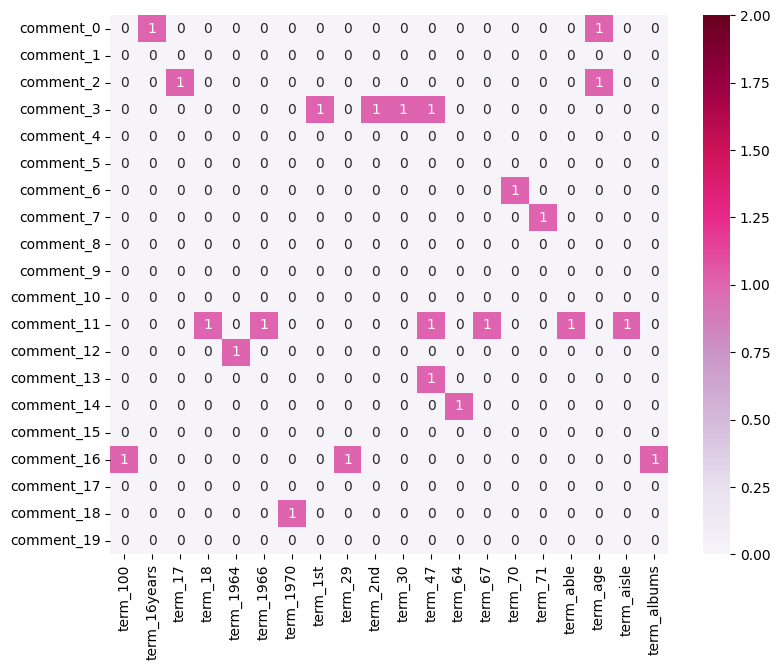

In [146]:
# Answer here

total = 0
arr = df_counts[0:20, 0:].toarray()
plot_x, plot_z = [], []
for i in range(20):
    tmp = []
    for i in range(20):
        tmp.append(-1)
    plot_z.append(tmp)

plot_y = ["comment_"+ str(i) for i in list(df.index)[0:20]]
for i in range(df_counts.shape[1]):
    flag = 0
    for j in range(20):
        plot_z[j][total] = arr[j][i]
        if arr[j][i] != 0:
            flag = 1

    if flag:
        total += 1
        plot_x.append("term_"+str(count_vect.get_feature_names_out()[i]))
        if total == 20:
            break

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=2, annot=True)

In [148]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []
for j in range(0,df_counts.shape[1]):
    term_frequencies.append(sum(df_counts[:,j].toarray()))

term_frequencies = np.asarray(df_counts.sum(axis=0))[0]
term_frequencies[0] #sum of first term: 00

np.int64(1)

C:\Users\USER\AppData\Local\Temp\ipykernel_13188\3480579971.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



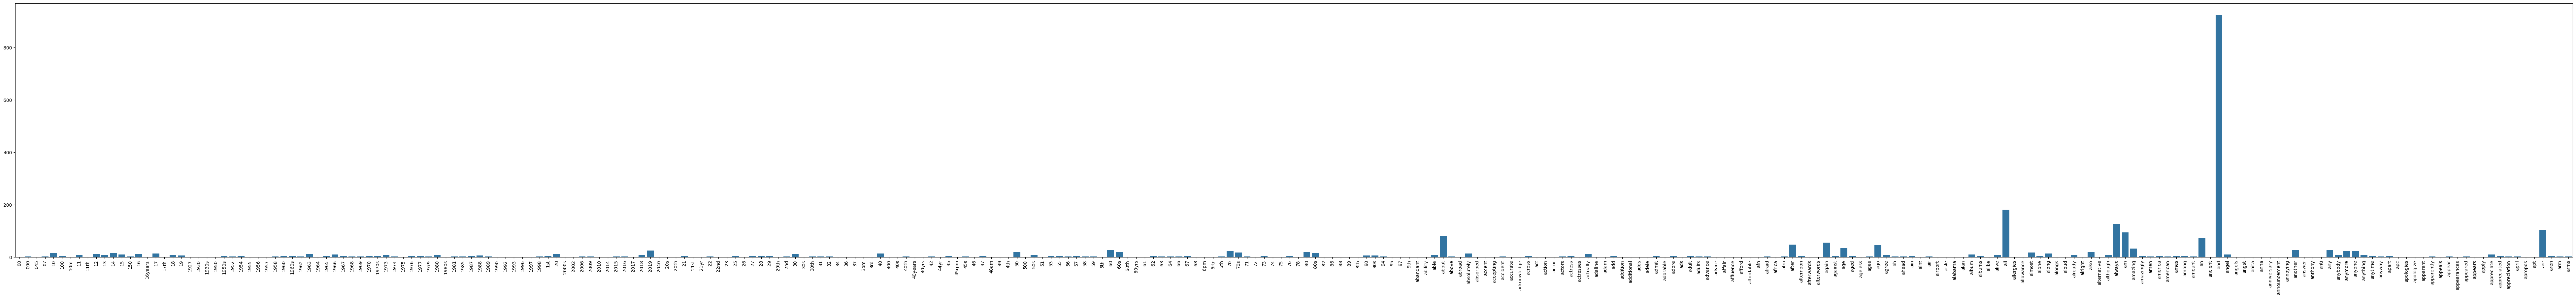

In [149]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

In [150]:
l = np.asarray(df_counts[:, :300].sum(axis=0))[0]
x = [i for i in count_vect.get_feature_names_out()[:300]]
data = pd.DataFrame({'Term': x,
                   'Term Freauency': l})

fig = px.bar(data, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title='Term Freauency'
            )
fig.update_layout(font_size=11)
fig.show()

In [151]:
# I select 100 terms which appear more than 20 times
l = np.asarray(df_counts[:, :].sum(axis=0))[0]
x, y = [], []
total = 0
for i in range(len(l)):
    if l[i] >= 20: # Only use the term if it appears more than 20 times
        x.append(count_vect.get_feature_names_out()[i])
        y.append(l[i])
        total += 1
    if total > 100:
        break
data = pd.DataFrame({'Term': x,
                   'Term Freauency': y})

fig = px.bar(data, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' 100 Terms occurrence more than 20 times'
            )
fig.update_layout(font_size=11)
fig.show()

In [153]:
# i select the top 300 most frequent terms
x = [i for i in count_vect.get_feature_names_out()]
y, x = zip(*sorted(zip(l, x)))
y = list(reversed(y))
x = list(reversed(x))
data = pd.DataFrame({'Term': x[:300], 'Term Freauency': y[:300]})
fig = px.bar(data, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' Top 300 most frequent terms'
            )
fig.update_layout(font_size=11)
fig.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_13188\1264328014.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, '00'),
 Text(1, 0, '000'),
 Text(2, 0, '045'),
 Text(3, 0, '07'),
 Text(4, 0, '10'),
 Text(5, 0, '100'),
 Text(6, 0, '10m'),
 Text(7, 0, '11'),
 Text(8, 0, '11th'),
 Text(9, 0, '12'),
 Text(10, 0, '13'),
 Text(11, 0, '14'),
 Text(12, 0, '15'),
 Text(13, 0, '150'),
 Text(14, 0, '16'),
 Text(15, 0, '16years'),
 Text(16, 0, '17'),
 Text(17, 0, '17th'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '1927'),
 Text(21, 0, '1930'),
 Text(22, 0, '1930s'),
 Text(23, 0, '1950'),
 Text(24, 0, '1950s'),
 Text(25, 0, '1952'),
 Text(26, 0, '1954'),
 Text(27, 0, '1955'),
 Text(28, 0, '1956'),
 Text(29, 0, '1957'),
 Text(30, 0, '1958'),
 Text(31, 0, '1960'),
 Text(32, 0, '1960s'),
 Text(33, 0, '1962'),
 Text(34, 0, '1963'),
 Text(35, 0, '1964'),
 Text(36, 0, '1965'),
 Text(37, 0, '1966'),
 Text(38, 0, '1967'),
 Text(39, 0, '1968'),
 Text(40, 0, '1969'),
 Text(41, 0, '1970'),
 Text(42, 0, '1970s'),
 Text(43, 0, '1973'),
 Text(44, 0, '1974'),
 Text(45, 0, '1975'),
 Text(46, 0, '1976')

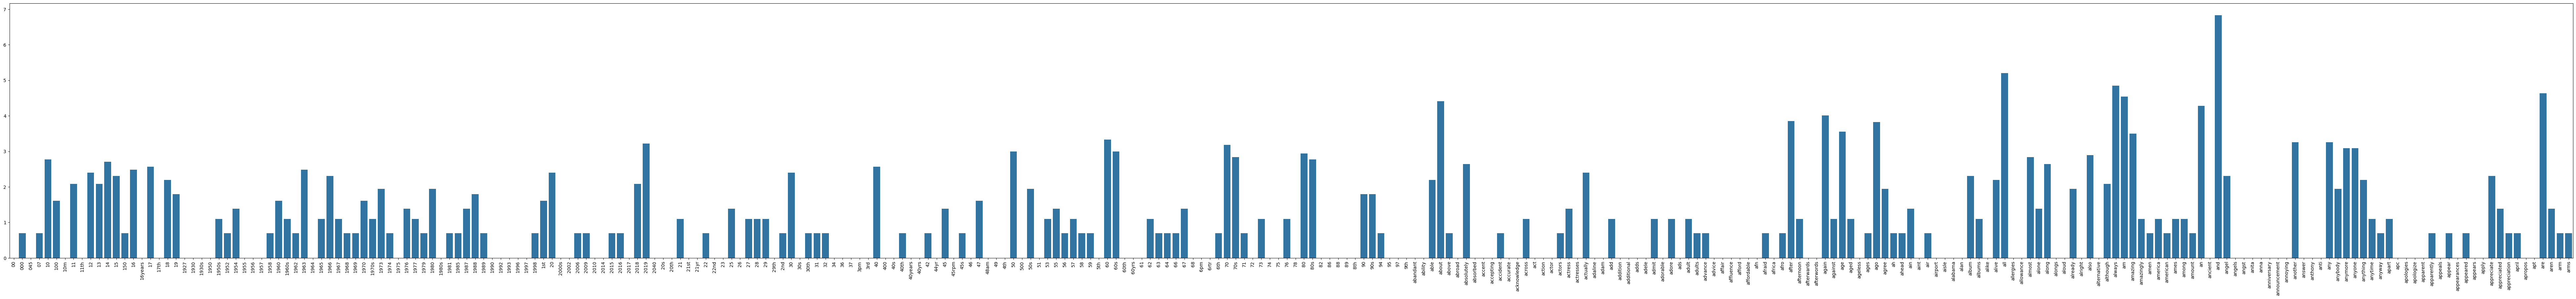

In [154]:
term_frequencies_log = [math.log(i) for i in term_frequencies]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90)

In [155]:
# i select the top 2000 most frequent terms and apply log transformation
x = [i for i in count_vect.get_feature_names_out()]
y, x = zip(*sorted(zip(l, x)))
y = list(reversed(y))
x = list(reversed(x))
y = [math.log(i) for i in y]
data = pd.DataFrame({'Term': x[:2000], 'Term Freauency': y[:2000]})
fig = px.bar(data, x='Term', y='Term Freauency',
             hover_data=['Term', 'Term Freauency'], color='Term Freauency',
             title=' Top 2000 most frequent terms'
            )
fig.update_layout(font_size=11)
fig.show()

In [157]:
#Create separate DataFrames for each category
categories = df['sentiment'].unique()  # Get unique category labels
category_dfs = {}  # Dictionary to store DataFrames for each category

for category in categories:
    # Filter the original DataFrame by category
    category_dfs[category] = df[df['sentiment'] == category].copy()

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer()  # Initialize the CountVectorizer
    X_counts = count_vect.fit_transform(df['comment'])  # Transform the text data into word counts
    
    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()
    
    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)
    
    return term_document_df

# Create term-document frequency DataFrames for each category
filt_term_document_dfs = {}  # Dictionary to store term-document DataFrames for each category

for category in categories:
    filt_term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [158]:
# Display the filtered DataFrame for one of the categories, feel free to change the number in the vector
category_number=0 #You can change it from 0 to 1
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filt_term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category not nostalgia:


00  000  045  10  100  10m  11  12  14  15  ...  youngest  youngsters  \
0     0    0    0   0    0    0   0   0   0   0  ...         0           0   
1     0    0    0   0    0    0   0   0   0   0  ...         0           0   
2     0    0    0   0    0    0   0   0   0   0  ...         0           0   
3     0    0    0   0    0    0   0   0   0   0  ...         0           0   
4     0    0    0   0    0    0   0   0   0   0  ...         0           0   
..   ..  ...  ...  ..  ...  ...  ..  ..  ..  ..  ...       ...         ...   
744   0    0    0   0    0    0   0   0   0   0  ...         0           0   
745   0    0    0   0    0    0   0   0   0   0  ...         0           0   
746   0    0    0   0    0    0   0   0   0   0  ...         0           0   
747   0    0    0   0    0    0   0   0   0   0  ...         0           0   
748   0    0    0   0    0    0   0   0   0   0  ...         0           0   

     your  yourself  youth  youtube  yrs  yuo  zealand  zulus  
0       0         0      0        0    0    0        0      0  
1       0         0      0        0    0    0        0      0  
2       0         0      0        0    0    0        0      0  
3       0         0      0        0    0    0        0      0  
4       0         0      0        0    0    0        0      0  
..    ...       ...    ...      ...  ...  ...      ...    ...  
744     0         0      0        0    0    0        0      0  
745     0         0      0        0    0    0        0      0  
746     0         0      0        0    0    0        0      0  
747     1         0      0        0    0    0        0      0  
748     0         0      0        0    0    0        0      0  

[749 rows x 2602 columns]

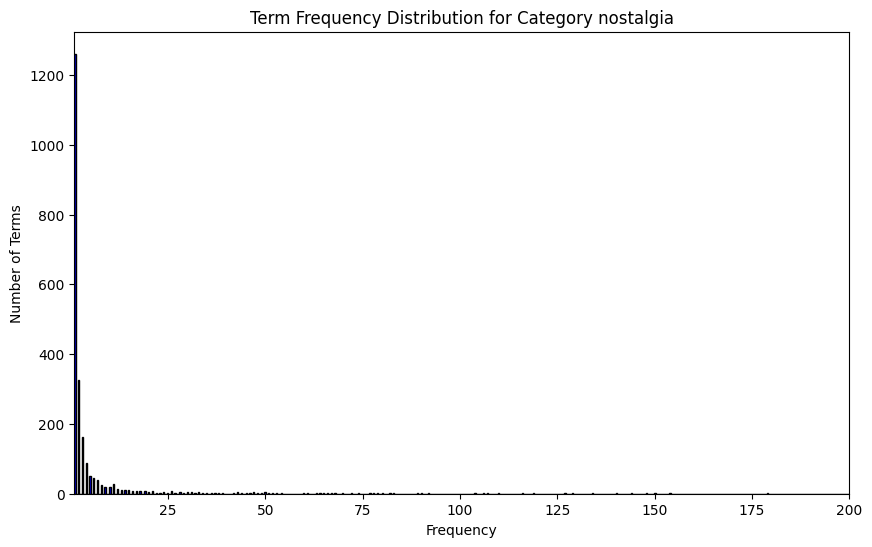

In [159]:
 # Sum over all documents to get total frequency for each word
category_number=1 #You can change it from 0 to 1
word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
 
# Visualize the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=2000, color='blue', edgecolor='black')
plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 200)
plt.show()

In [160]:
category_number=0 #You can change it from 0 to 1
word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Sort the term frequencies in descending order
sorted_indices = np.argsort(word_counts)[::-1]  # Get indices of sorted frequencies
sorted_counts = np.sort(word_counts)[::-1]  # Sort frequencies in descending order

# Calculate the index corresponding to the top 5% most frequent terms
total_terms = len(sorted_counts)
top_5_percent_index = int(0.05 * total_terms)

# Get the indices of the top 5% most frequent terms
top_5_percent_indices = sorted_indices[:top_5_percent_index]

# Filter terms that belong to the top 5% based on their rank
filtered_words = [filt_term_document_dfs[categories[category_number]].iloc[:, i].name for i in top_5_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in top 5%: {top_5_percent_index}")
print(f"Filtered terms: {filtered_words}")


Category: not nostalgia
Number of terms in top 5%: 130
Filtered terms: ['the', 'this', 'and', 'to', 'of', 'song', 'it', 'is', 'in', 'you', 'that', 'my', 'love', 'music', 'was', 'for', 'so', 'have', 'one', 'like', 'but', 'he', 'with', 'great', 'all', 'not', 'what', 'on', 'be', 'can', 'voice', 'me', 'just', 'songs', 'as', 'beautiful', 'her', 'time', 'she', 'will', 'they', 'when', 'from', 'his', 'at', 'are', 'always', 'good', 'no', 'know', 'now', 'never', 'about', 'much', 'who', 'really', 'if', 'we', 'more', 'best', 'by', 'ever', 'thank', 'think', 'would', 'only', 'don', 'still', 'how', 'has', 'very', 'am', 'there', 'out', 'could', 'him', 'these', 'old', 'up', 'do', 'listen', 'hear', 'an', 'singer', 'had', 'many', 'here', 'too', 'version', 'such', 'today', 'been', 'most', 'get', 'world', 'people', 'your', 'man', 'heard', 'some', 'video', 'listening', 'sing', 'years', 'real', 'were', 'than', 'singing', 'heart', 'nice', 'their', 'better', 'life', 'its', 'day', 'sad', 'those', 'then', 'god',

In [162]:
category_number=0 #You can change it from 0 to 1

# Filter the bottom 1% and top 5% words based on their sum across all documents
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    # Calculate the sum of each word across all documents
    word_sums = term_document_df.sum(axis=0)
    
    # Sort the words by their total sum
    sorted_words = word_sums.sort_values()
    
    # Calculate the number of words to remove
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    # Get the words to remove from the top 5% and bottom 1%
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    print(f'Bottom {bottom_percent*100}% words: \n{sorted_words.head(bottom_n)}') #Here we print which words correspond to the bottom percentage we filter
    print(f'Top {top_percent*100}% words: \n{sorted_words.tail(top_n)}') #Here we print which words correspond to the top percentage we filter
    # Return the DataFrame without the filtered words
    return term_document_df.drop(columns=words_to_remove)

# Apply the filtering function to each category
term_document_dfs = {}

for category in categories:
    print(f'\nFor category {category} we filter the following words:')
    term_document_dfs[category] = filter_top_bottom_words_by_sum(filt_term_document_dfs[category])

# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
term_document_dfs[categories[category_number]]



For category not nostalgia we filter the following words:
Bottom 1.0% words: 
20th           1
21st           1
21yr           1
28             1
30s            1
30th           1
32             1
37             1
1952           1
1955           1
1957           1
12             1
2010           1
2017           1
2018           1
2040           1
worthwhile     1
64             1
67             1
74             1
76             1
95             1
1930           1
1930s          1
wonderfully    1
wondering      1
dtype: int64
Top 5.0% words: 
them        23
amazing     23
got         23
wish        24
or          25
          ... 
of         361
to         394
and        451
this       452
the        708
Length: 130, dtype: int64

For category nostalgia we filter the following words:
Bottom 1.0% words: 
1964          1
1969          1
1975          1
1980s         1
1981          1
wonderfull    1
wood          1
working       1
mad           1
maddox        1
madrid        1
maggie 

00  000  045  10  100  10m  11  14  15  150  ...  younger  youngest  \
0     0    0    0   0    0    0   0   0   0    0  ...        0         0   
1     0    0    0   0    0    0   0   0   0    0  ...        0         0   
2     0    0    0   0    0    0   0   0   0    0  ...        0         0   
3     0    0    0   0    0    0   0   0   0    0  ...        0         0   
4     0    0    0   0    0    0   0   0   0    0  ...        0         0   
..   ..  ...  ...  ..  ...  ...  ..  ..  ..  ...  ...      ...       ...   
744   0    0    0   0    0    0   0   0   0    0  ...        0         0   
745   0    0    0   0    0    0   0   0   0    0  ...        0         0   
746   0    0    0   0    0    0   0   0   0    0  ...        0         0   
747   0    0    0   0    0    0   0   0   0    0  ...        0         0   
748   0    0    0   0    0    0   0   0   0    0  ...        0         0   

     youngsters  yourself  youth  youtube  yrs  yuo  zealand  zulus  
0             0         0      0        0    0    0        0      0  
1             0         0      0        0    0    0        0      0  
2             0         0      0        0    0    0        0      0  
3             0         0      0        0    0    0        0      0  
4             0         0      0        0    0    0        0      0  
..          ...       ...    ...      ...  ...  ...      ...    ...  
744           0         0      0        0    0    0        0      0  
745           0         0      0        0    0    0        0      0  
746           0         0      0        0    0    0        0      0  
747           0         0      0        0    0    0        0      0  
748           0         0      0        0    0    0        0      0  

[749 rows x 2446 columns]

In [163]:
# Loop through the dictionary of term-document DataFrames
for category in term_document_dfs:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace('.', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(term_document_dfs[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}.csv', '>=', 1)

Database size (total no of transactions) : 734
Number of items : 2159
Minimum Transaction Size : 1
Average Transaction Size : 8.693460490463215
Maximum Transaction Size : 39
Standard Deviation Transaction Size : 7.227146505233723
Variance in Transaction Sizes : 52.30290397046961
Sparsity : 0.9959733855996001


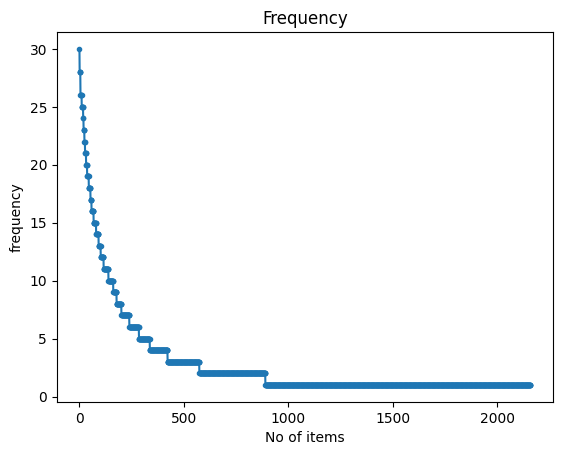

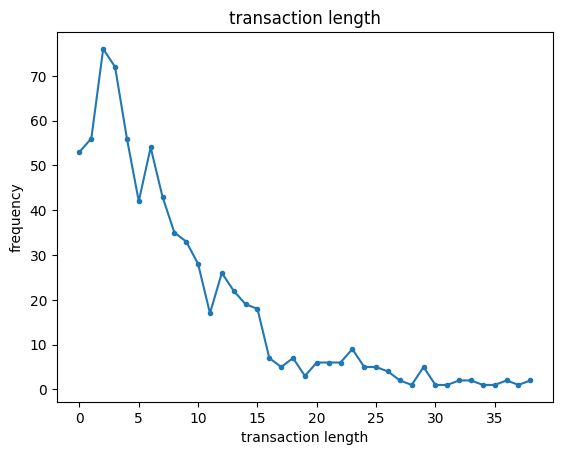

In [166]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [167]:
minSup=5
obj1 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=minSup)
obj1.mine()
frequentPatternsDF_nostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) #print the total number of patterns
print('Runtime: ' + str(obj1.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 364
Runtime: 0.026501178741455078


Database size (total no of transactions) : 746
Number of items : 2446
Minimum Transaction Size : 1
Average Transaction Size : 8.400804289544237
Maximum Transaction Size : 47
Standard Deviation Transaction Size : 5.923683496167718
Variance in Transaction Sizes : 35.137126869028556
Sparsity : 0.9965654929315028
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 355
Runtime: 0.016161203384399414


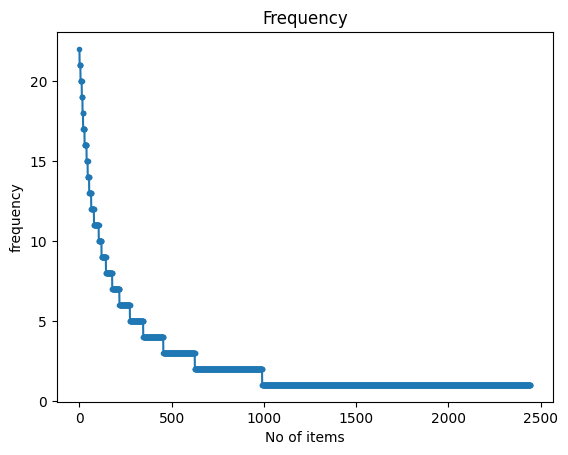

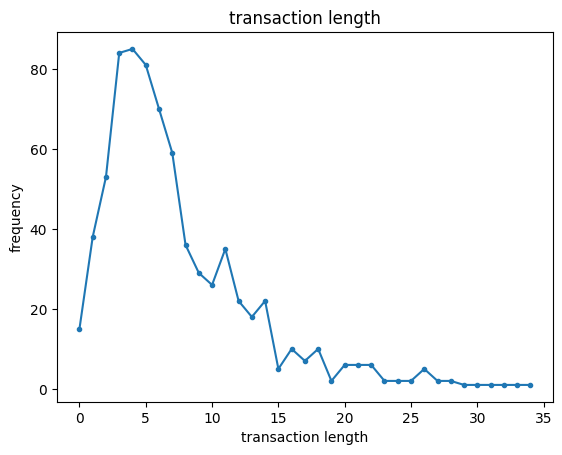

In [168]:
obj = tds.TransactionalDatabase('td_freq_db_not nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

obj2 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup=minSup)
obj2.mine()
frequentPatternsDF_not_nostalgia= obj2.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_not_nostalgia))) #print the total number of patterns
print('Runtime: ' + str(obj2.getRuntime())) #measure the runtime

In [133]:
#We group together all of the dataframes related to our found patterns
dfs = [frequentPatternsDF_not_nostalgia, frequentPatternsDF_nostalgia]


# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for i in dfs:
    for pattern in i['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(i) for i in dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for i in dfs:
    filtered_df = i[i['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")

           Patterns  Support
384            will       28
382            ever       28
383           would       28
380            wish       26
378            them       26
..              ...      ...
327        don know        5
332        boy long        5
333       see could        5
340  feel nostalgic        5
351        being go        5

[385 rows x 2 columns]
Number of patterns discarded: 334


In [174]:
# Convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
df_tdm = count_vect.fit_transform(df['comment'])  # X['comment'] contains your text data
terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
df['tokenized_text'] = df['comment'].str.split().apply(set)

# Initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=df.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = df['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(df_tdm.toarray(), columns=terms, index=df.index)

# Concatenate the original TDM and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df

00  000  045  07  10  100  10m  11  11th  12  ...  likes  running  \
0      0    0    0   0   0    0    0   0     0   0  ...      0        0   
1      0    0    0   0   0    0    0   0     0   0  ...      0        0   
2      0    0    0   0   0    0    0   0     0   0  ...      0        0   
3      0    0    0   0   0    0    0   0     0   0  ...      0        0   
4      0    0    0   0   0    0    0   0     0   0  ...      0        0   
...   ..  ...  ...  ..  ..  ...  ...  ..   ...  ..  ...    ...      ...   
1495   0    0    0   0   0    0    0   0     0   0  ...      0        0   
1496   0    0    0   0   0    0    0   0     0   0  ...      0        0   
1497   0    0    0   0   0    0    0   0     0   0  ...      0        0   
1498   0    0    0   0   0    0    0   0     0   0  ...      0        0   
1499   0    0    0   0   0    0    0   0     0   0  ...      0        0   

      beauty  learn  comes  don know  boy long  see could  feel nostalgic  \
0          0      0      0         0         0          0               0   
1          0      0      0         0         0          0               0   
2          0      0      0         0         0          0               0   
3          0      0      0         0         0          0               0   
4          0      0      0         0         0          0               0   
...      ...    ...    ...       ...       ...        ...             ...   
1495       0      0      0         0         0          0               0   
1496       0      0      0         0         0          0               0   
1497       0      0      1         0         0          0               0   
1498       0      0      0         0         0          0               0   
1499       0      0      0         0         0          0               0   

      being go  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
1495         0  
1496         0  
1497         0  
1498         0  
1499         0  

[1499 rows x 4115 columns]

In [180]:
topk, maxFPG = [], []
obj = top_alg.FAE(iFile='td_freq_db_nostalgia.csv', k=200)
obj.mine()
frequentPatterns1 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = top_alg.FAE(iFile='td_freq_db_nostalgia.csv', k=400)
obj.mine()
frequentPatterns2 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = top_alg.FAE(iFile='td_freq_db_nostalgia.csv', k=600)
obj.mine()
frequentPatterns3 = obj.getPatternsAsDataFrame()
topk.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=3)
obj.mine()
frequentPatterns4 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=6)
obj.mine()
frequentPatterns5 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

obj = max_alg.MaxFPGrowth(iFile='td_freq_db_nostalgia.csv', minSup=9)
obj.mine()
frequentPatterns6 = obj.getPatternsAsDataFrame()
maxFPG.append(obj.getRuntime())

print('FAE Top-k:')
print('k = 200:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns1)))
print('  ' + 'Runtime: ' + str(topk[0]))
print('k = 400:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns2)))
print('  ' + 'Runtime: ' + str(topk[1]))
print('k = 600:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns3)))
print('  ' + 'Runtime: ' + str(topk[2]))
print('MaxFPGrowth:')
print('minSup = 3:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns4)))
print('  ' + 'Runtime: ' + str(maxFPG[0]))
print('minSup = 6:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns5)))
print('  ' + 'Runtime: ' + str(maxFPG[1]))
print('minSup = 9:')
print('  ' + 'Total No of patterns: ' + str(len(frequentPatterns6)))
print('  ' + 'Runtime: ' + str(maxFPG[2]))

 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
FAE Top-k:
k = 200:
  Total No of patterns: 200
  Runtime: 0.026134490966796875
k = 400:
  Total No of patterns: 400
  Runtime: 0.07819581031799316
k = 600:
  Total No of patterns: 600
  Runtime: 0.17011713981628418
MaxFPGrowth:
minSup = 3:
  Total No of patterns: 682
  Runtime: 0.5313847064971924
minSup = 6:
  Total No of patterns: 274
  Runtime: 0.022935152053833008
minSup = 9:
  Total No of patterns: 176
  Runtime: 0.013424158096313477


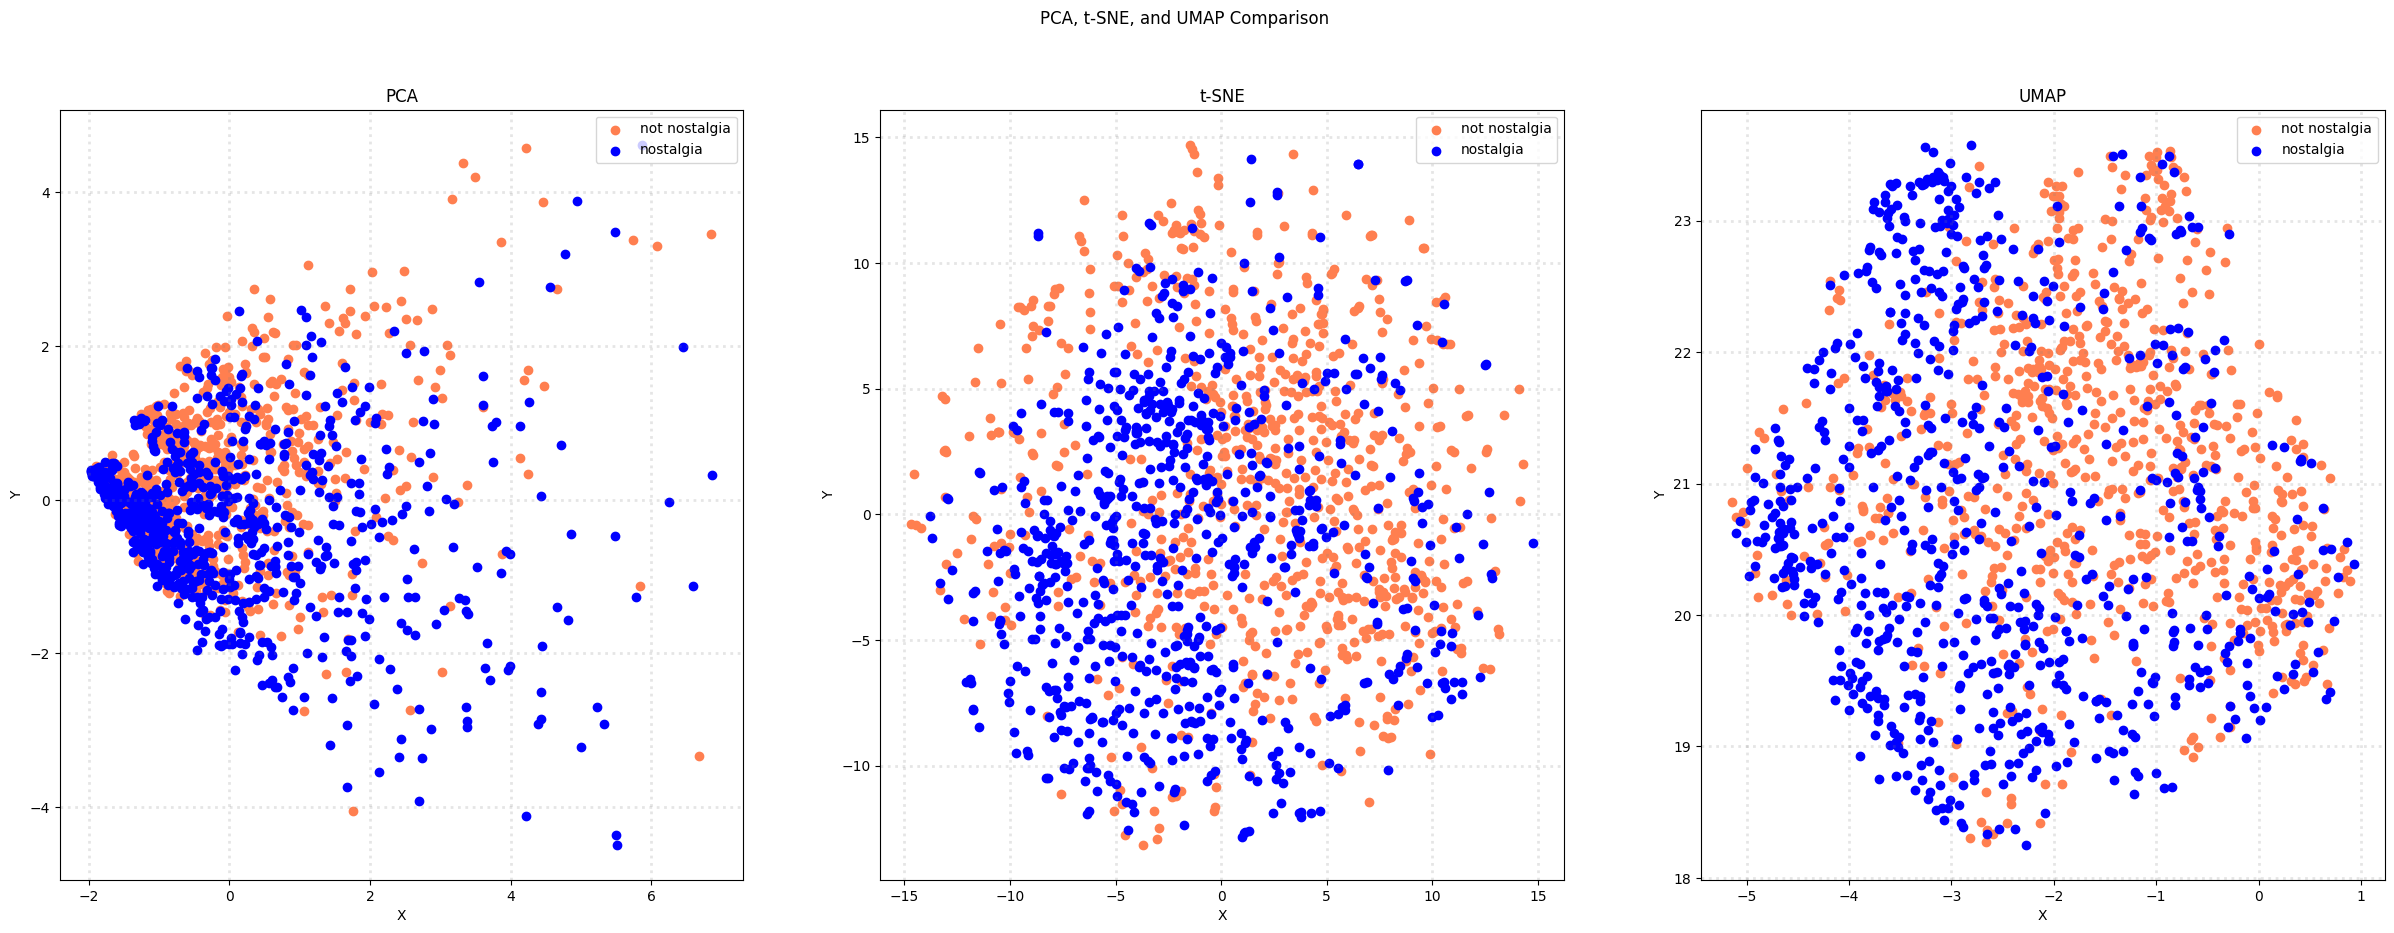

In [183]:
#This might take a couple of minutes to execute
# Apply PCA, t-SNE, and UMAP to the data
X_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
X_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
X_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = df['sentiment'].unique() 

fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[df['sentiment'] == category].T[0]
        ys = X_reduced[df['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_tdm, 'PCA')
plot_scatter(axes[1], X_tsne_tdm, 't-SNE')
plot_scatter(axes[2], X_umap_tdm, 'UMAP')

plt.show()

In [186]:
X_pca_aug = PCA(n_components=3).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=3).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=3).fit_transform(augmented_df.values)

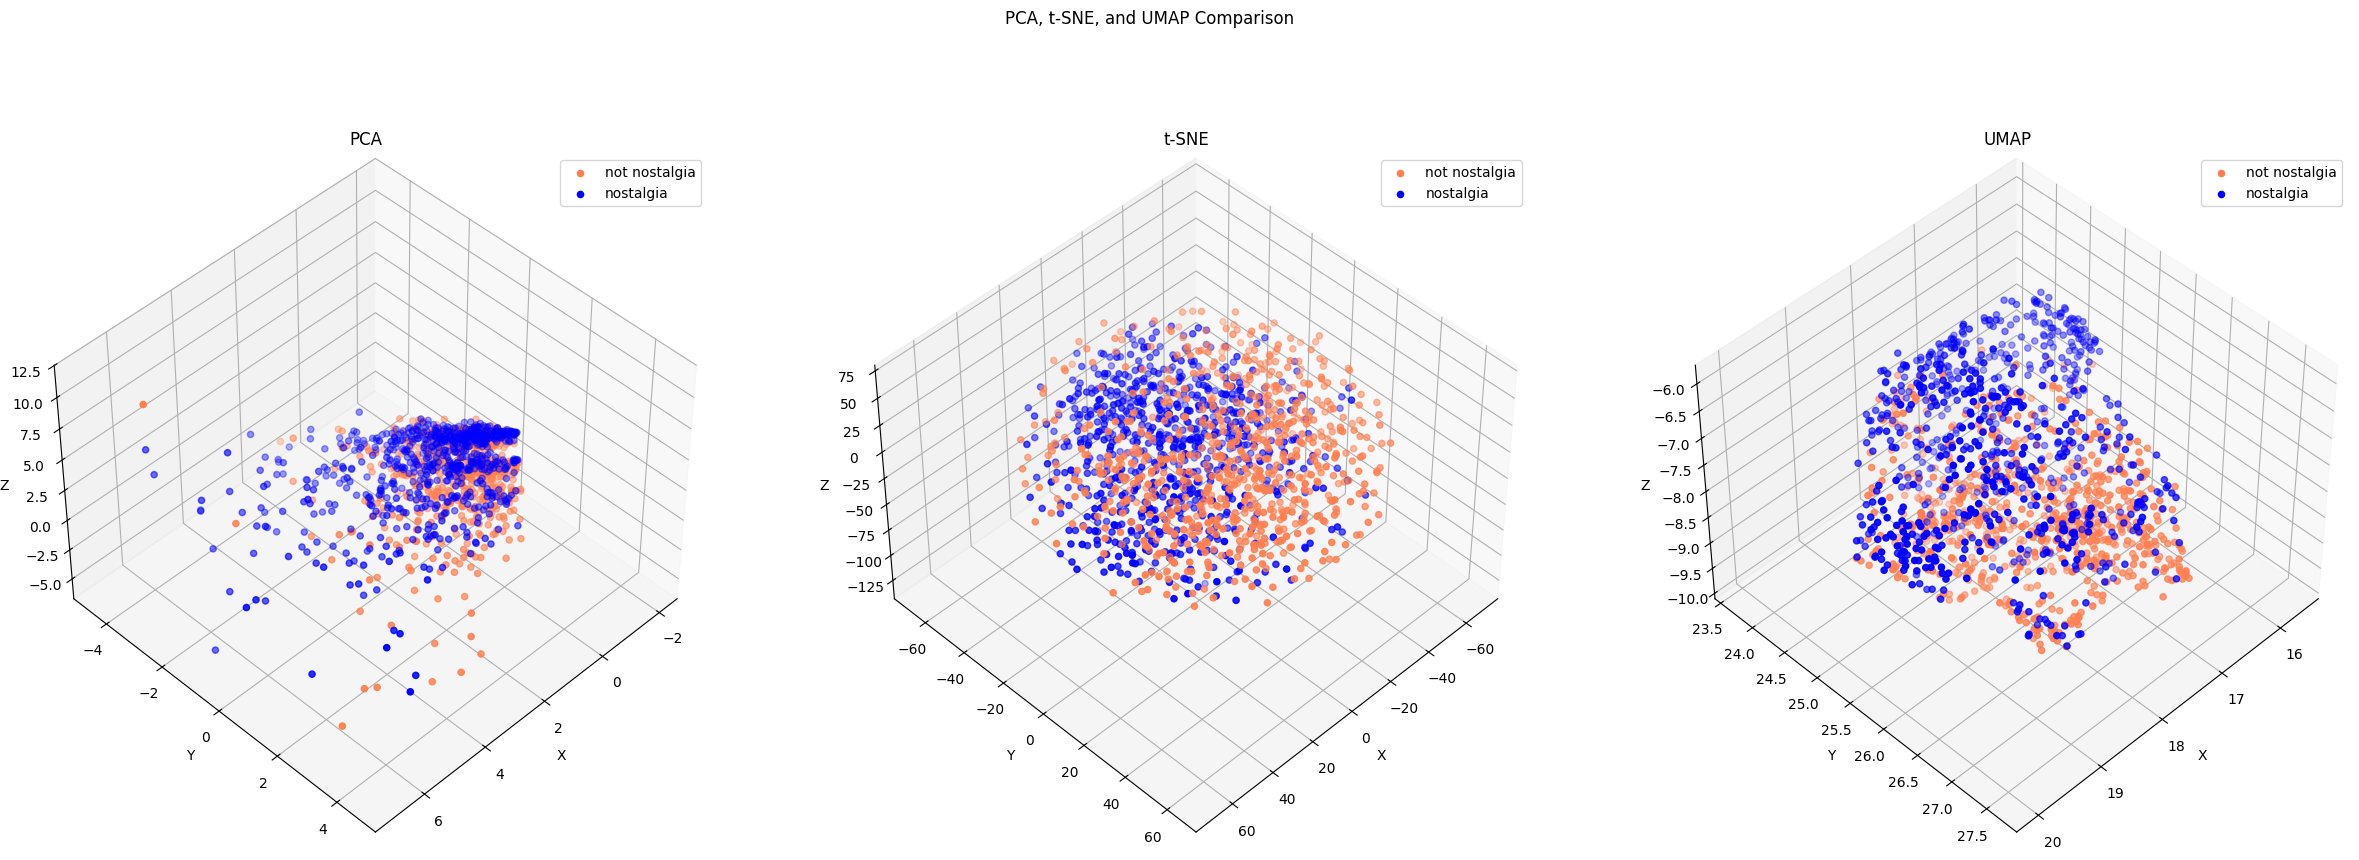

In [187]:
# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title, elev, azim):
    for c, category in zip(col, categories):
        xs = X_reduced[df['sentiment'] == category].T[0]
        ys = X_reduced[df['sentiment'] == category].T[1]
        zs = X_reduced[df['sentiment'] == category].T[2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')

    ax.view_init(elev=elev, azim=-azim)

# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = df['sentiment'].unique() 

fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')


# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(ax1, X_pca_aug, 'PCA', 45, -45)
plot_scatter(ax2, X_tsne_aug, 't-SNE', 45, -45)
plot_scatter(ax3, X_umap_aug, 'UMAP', 45, -45)



plt.show()

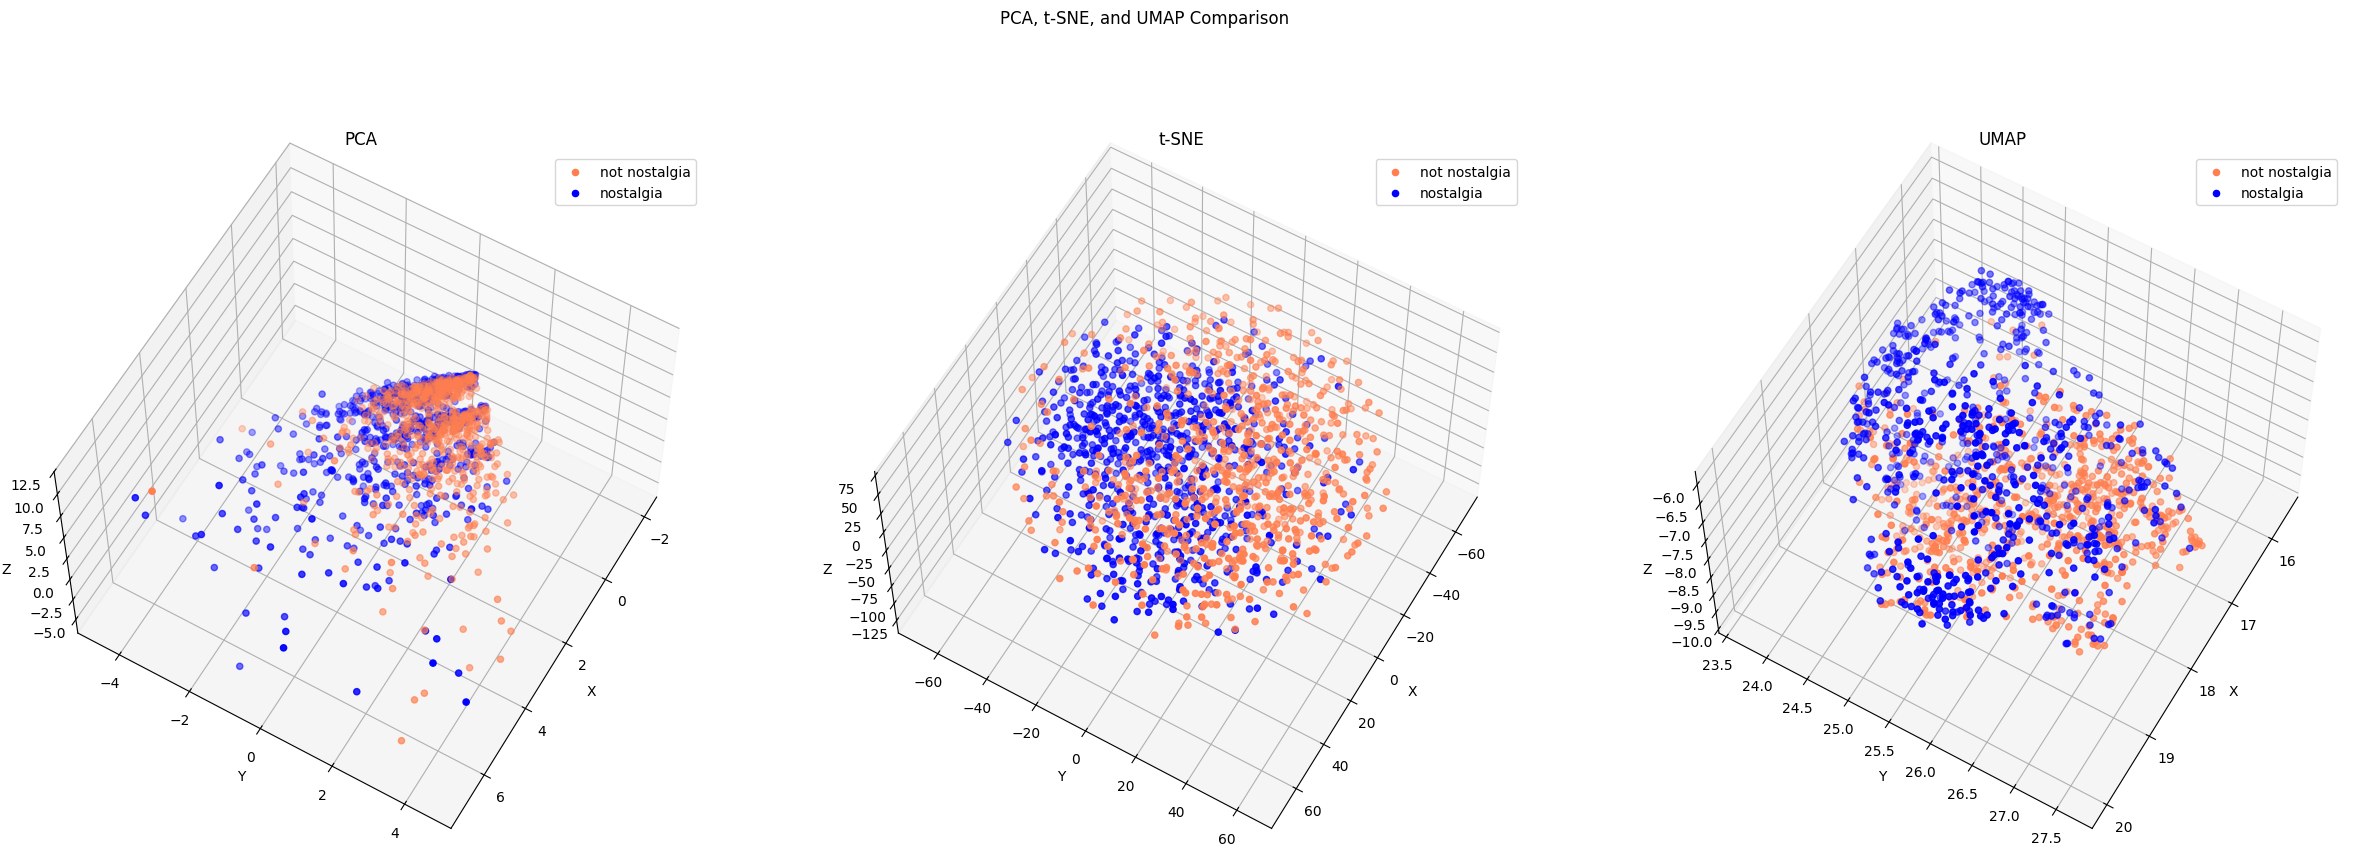

In [188]:
fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax4 = fig.add_subplot(131, projection='3d')
ax5 = fig.add_subplot(132, projection='3d')
ax6 = fig.add_subplot(133, projection='3d')
plot_scatter(ax4, X_pca_aug, 'PCA', 60, -30)
plot_scatter(ax5, X_tsne_aug, 't-SNE', 60, -30)
plot_scatter(ax6, X_umap_aug, 'UMAP', 60, -30)
plt.show()

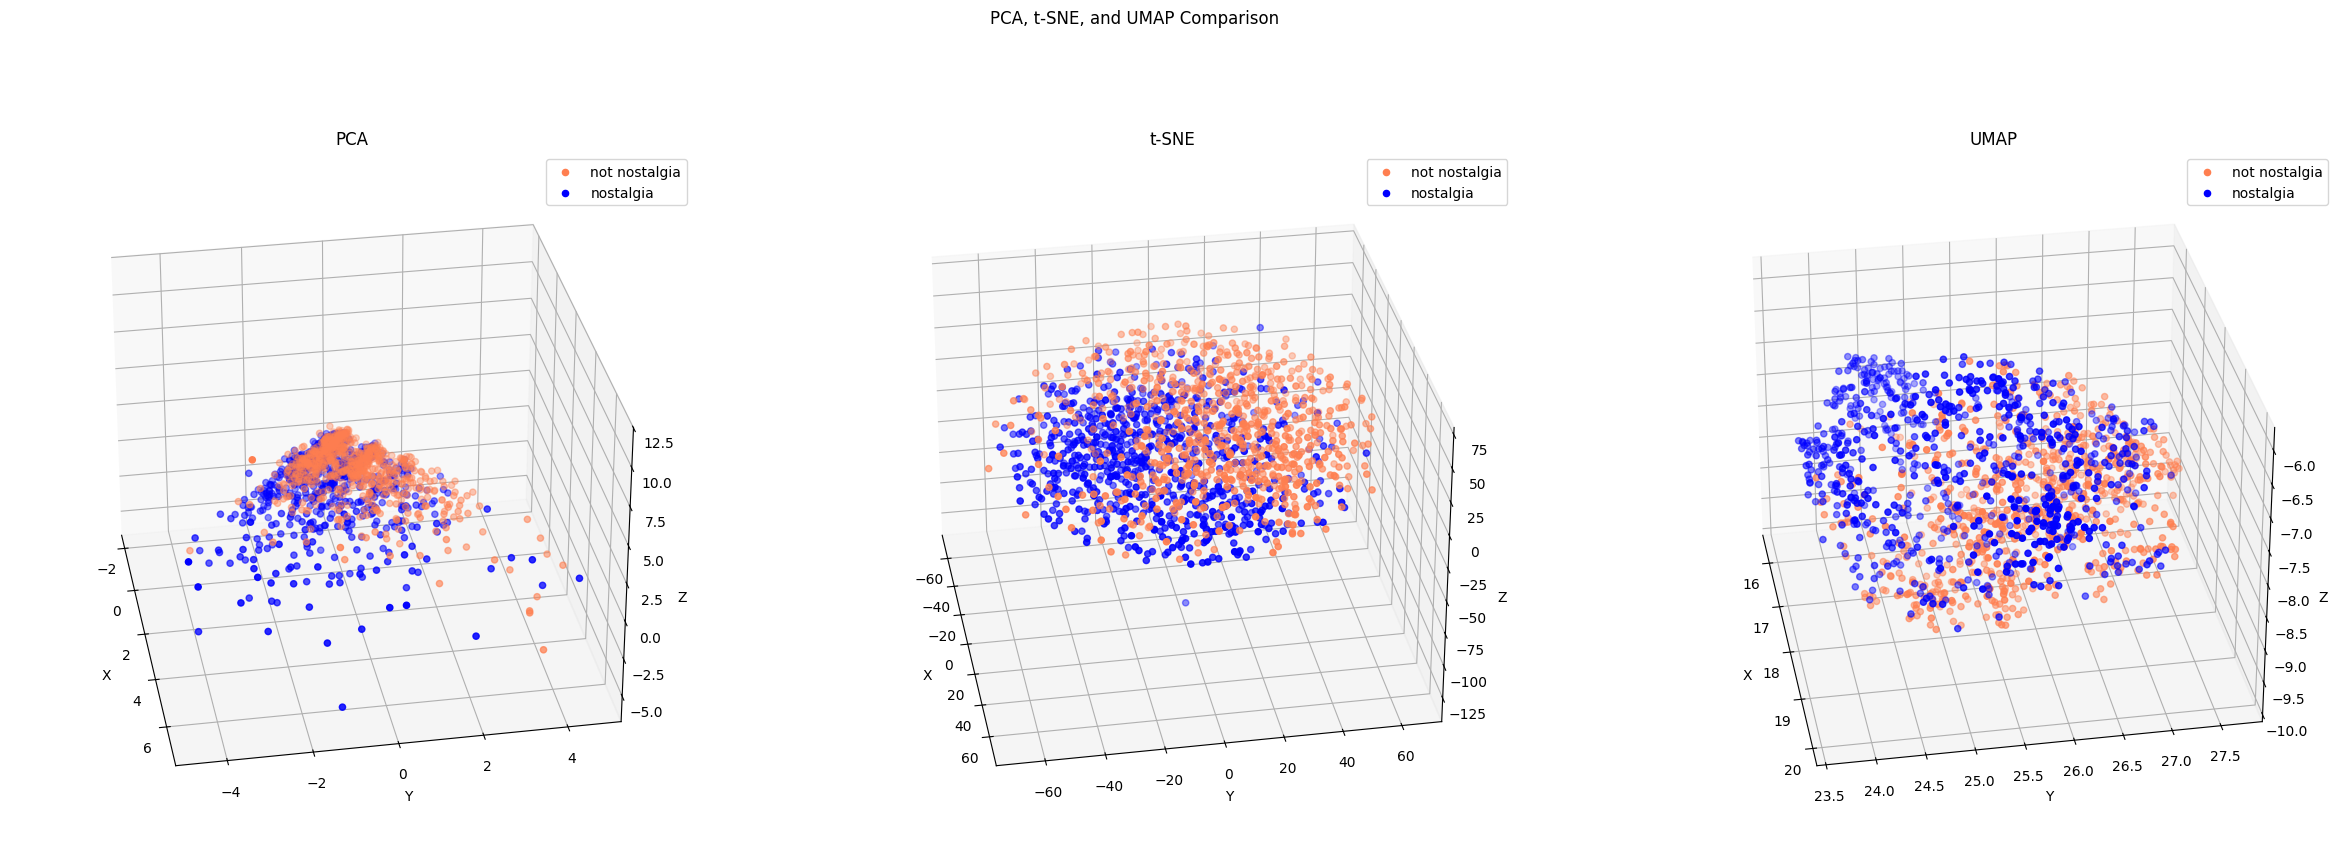

In [189]:
fig = plt.figure(figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax7 = fig.add_subplot(131, projection='3d')
ax8 = fig.add_subplot(132, projection='3d')
ax9 = fig.add_subplot(133, projection='3d')
plot_scatter(ax7, X_pca_aug, 'PCA', 30, 10)
plot_scatter(ax8, X_tsne_aug, 't-SNE', 30, 10)
plot_scatter(ax9, X_umap_aug, 'UMAP', 30, 10)
plt.show()

In [190]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(df.sentiment)
df['bin_category'] = mlb.transform(df['sentiment']).tolist()
df[:9]

sentiment                                            comment  \
0  not nostalgia  He was a singer with a golden voice that I lov...   
1      nostalgia  The mist beautiful voice ever I listened to hi...   
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...   
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...   
4      nostalgia  listening to his songs reminds me of my mum wh...   
5      nostalgia  Every time I heard this song as a child, I use...   
6      nostalgia  My dad loved listening to Jim Reeves, when I w...   
7      nostalgia  i HAVE ALSO LISTENED TO Jim Reeves since child...   
8  not nostalgia           Wherever you  are you always in my heart   

   sentiment_num                                           unigrams  \
0              0  [He, was, a, singer, with, a, golden, voice, t...   
1              1  [The, mist, beautiful, voice, ever, I, listene...   
2              1  [I, have, most, of, Mr., Reeves, songs, ., Alw...   
3              0  [30, day, leave, from, 1st, tour, in, Viet, Na...   
4              1  [listening, to, his, songs, reminds, me, of, m...   
5              1  [Every, time, I, heard, this, song, as, a, chi...   
6              1  [My, dad, loved, listening, to, Jim, Reeves, ,...   
7              1  [i, HAVE, ALSO, LISTENED, TO, Jim, Reeves, sin...   
8              0   [Wherever, you, are, you, always, in, my, heart]   

                                      tokenized_text bin_category  
0  {Reeves, now,, I, love, a, 16years, many, for,...          [1]  
1  {listened, I, The, when, love, a, singing, eve...          [0]  
2  {Reeves, had, job, find, no, is., smooth, neve...          [0]  
3  {who, "marry, I, pray, when, 47, back, receive...          [1]  
4  {reminds, him, me, his, mum, songs, who, every...          [0]  
5  {I, your, time, funerals., cry....because, a, ...          [0]  
6  {I, when, back, do, 70's, but, a, for, then,, ...          [0]  
7  {Reeves, puts, I, love, tunes, comes, ., a, mu...          [0]  
8        {Wherever, heart, you, in, my, are, always}          [1]

In [192]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(df.sentiment_num)
df['bin_category_num'] = mlb.transform(df['sentiment_num']).tolist()
df[:9]
# In this case, the result of bin_category and bin_category_num are opposite

sentiment                                            comment  \
0  not nostalgia  He was a singer with a golden voice that I lov...   
1      nostalgia  The mist beautiful voice ever I listened to hi...   
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...   
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...   
4      nostalgia  listening to his songs reminds me of my mum wh...   
5      nostalgia  Every time I heard this song as a child, I use...   
6      nostalgia  My dad loved listening to Jim Reeves, when I w...   
7      nostalgia  i HAVE ALSO LISTENED TO Jim Reeves since child...   
8  not nostalgia           Wherever you  are you always in my heart   

   sentiment_num                                           unigrams  \
0              0  [He, was, a, singer, with, a, golden, voice, t...   
1              1  [The, mist, beautiful, voice, ever, I, listene...   
2              1  [I, have, most, of, Mr., Reeves, songs, ., Alw...   
3              0  [30, day, leave, from, 1st, tour, in, Viet, Na...   
4              1  [listening, to, his, songs, reminds, me, of, m...   
5              1  [Every, time, I, heard, this, song, as, a, chi...   
6              1  [My, dad, loved, listening, to, Jim, Reeves, ,...   
7              1  [i, HAVE, ALSO, LISTENED, TO, Jim, Reeves, sin...   
8              0   [Wherever, you, are, you, always, in, my, heart]   

                                      tokenized_text bin_category  \
0  {Reeves, now,, I, love, a, 16years, many, for,...          [1]   
1  {listened, I, The, when, love, a, singing, eve...          [0]   
2  {Reeves, had, job, find, no, is., smooth, neve...          [0]   
3  {who, "marry, I, pray, when, 47, back, receive...          [1]   
4  {reminds, him, me, his, mum, songs, who, every...          [0]   
5  {I, your, time, funerals., cry....because, a, ...          [0]   
6  {I, when, back, do, 70's, but, a, for, then,, ...          [0]   
7  {Reeves, puts, I, love, tunes, comes, ., a, mu...          [0]   
8        {Wherever, heart, you, in, my, are, always}          [1]   

  bin_category_num  
0              [0]  
1              [1]  
2              [1]  
3              [0]  
4              [1]  
5              [1]  
6              [1]  
7              [1]  
8              [0]

In [198]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = df.iloc[50]
random_record_1 = random_record_1['comment']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = df.iloc[100]
random_record_2 = random_record_2['comment']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = df.iloc[150]
random_record_3 = random_record_3['comment']
document_to_transform_3.append(random_record_3)

print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

['If I remember correctly, this song came out after Mr. Reeves passed away. I was about 10 years old when the disc jockey said that the news just came over the wire that he died in a plane crash.']
['i guess most of us leave it too late before we tell someone just how much we really love them']
['my name is thomas but know by tommy and my wifes name is laura and i always sing this to her']
Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [197]:
# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.032174
Cosine Similarity using count bw 1 and 3: 0.027864
Cosine Similarity using count bw 2 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_13188\3530576229.py:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\USER\AppData\Local\Temp\ipykernel_13188\3530576229.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\USER\AppData\Local\Temp\ipykernel_13188\3530576229.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\USER\AppData\Local\Temp\ipykernel_13188\3530576229.py:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a 

In [208]:
# Create a mapping from numerical labels to category names
category_mapping = dict(df[['sentiment_num', 'sentiment']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, df['sentiment'], test_size=0.3, random_state=42)

In [210]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8688888888888889

Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.8222    0.9528    0.8827       233
    nostalgia     0.9389    0.7788    0.8514       217

     accuracy                         0.8689       450
    macro avg     0.8806    0.8658    0.8670       450
 weighted avg     0.8785    0.8689    0.8676       450



---

# Part Three

In [6]:
# Read the dataset
df = pd.read_csv('Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv')
print(df.shape)
print(df.sentiment.value_counts())
print(df.head())

(1500, 2)
sentiment
not nostalgia    750
nostalgia        750
Name: count, dtype: int64
       sentiment                                            comment
0  not nostalgia  He was a singer with a golden voice that I lov...
1      nostalgia  The mist beautiful voice ever I listened to hi...
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4      nostalgia  listening to his songs reminds me of my mum wh...


In [7]:
df['sentiment_num'] = df.sentiment.apply(lambda x : 1 if x == 'nostalgia' else 0)
df.head()

sentiment                                            comment  \
0  not nostalgia  He was a singer with a golden voice that I lov...   
1      nostalgia  The mist beautiful voice ever I listened to hi...   
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...   
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...   
4      nostalgia  listening to his songs reminds me of my mum wh...   

   sentiment_num  
0              0  
1              1  
2              1  
3              0  
4              1

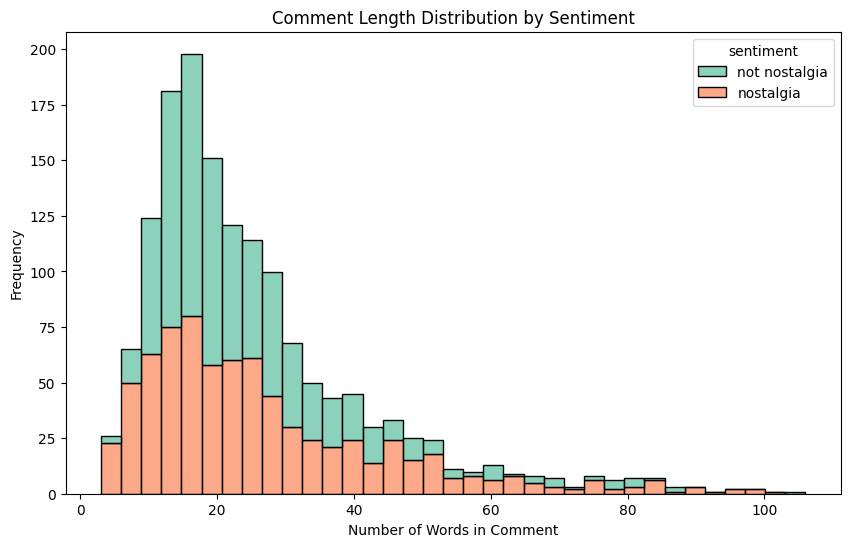

In [80]:
# Plot the histogram according to the length of comment
df['comment_length'] = df['comment'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='comment_length', hue='sentiment', multiple='stack', palette='Set2')
plt.title('Comment Length Distribution by Sentiment')
plt.xlabel('Number of Words in Comment')
plt.ylabel('Frequency')
plt.show()

In [100]:
# By analyzing the histogram, we can notice that comments belong to nostalgia are more likely to be longer
df[df['comment_length'] > 45].sentiment.value_counts()

sentiment
nostalgia        116
not nostalgia     59
Name: count, dtype: int64

Train the model by using word frequency

In [114]:
# Convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(df['comment'])
terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary
# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=df.index)
tdm_df.head()

00  000  045  07  10  100  10m  11  11th  12  ...  yours  yourself  youth  \
0   0    0    0   0   0    0    0   0     0   0  ...      0         0      0   
1   0    0    0   0   0    0    0   0     0   0  ...      0         0      0   
2   0    0    0   0   0    0    0   0     0   0  ...      0         0      0   
3   0    0    0   0   0    0    0   0     0   0  ...      0         0      0   
4   0    0    0   0   0    0    0   0     0   0  ...      0         0      0   

   youthful  youtube  yrs  yuo  yup  zealand  zulus  
0         0        0    0    0    0        0      0  
1         0        0    0    0    0        0      0  
2         0        0    0    0    0        0      0  
3         0        0    0    0    0        0      0  
4         0        0    0    0    0        0      0  

[5 rows x 3730 columns]

In [115]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, df['sentiment_num'], test_size=0.3, random_state=99, stratify=df.sentiment_num)
y_train.value_counts()

sentiment_num
1    525
0    525
Name: count, dtype: int64

In [116]:
# Train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8622222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.86       225
           1       0.83      0.91      0.87       225

    accuracy                           0.86       450
   macro avg       0.87      0.86      0.86       450
weighted avg       0.87      0.86      0.86       450



In [117]:
# Train the Bernoulli Naive Bayes classifier
nb_classifier = BernoulliNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8888888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       225
           1       0.88      0.90      0.89       225

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450



Train the model by using word TFIDF

In [118]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df.comment)
terms = vectorizer.get_feature_names_out()  # Original terms in the vocabulary
# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X.toarray(), columns=terms, index=df.index)
tdm_df.head()

00  000  045   07   10  100  10m   11  11th   12  ...  yours  yourself  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   

   youth  youthful  youtube  yrs  yuo  yup  zealand  zulus  
0    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
1    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
2    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
3    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
4    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  

[5 rows x 3730 columns]

In [119]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, df['sentiment_num'], test_size=0.3, random_state=99, stratify=df.sentiment_num)
y_train.value_counts()

sentiment_num
1    525
0    525
Name: count, dtype: int64

In [120]:
# Train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85       225
           1       0.82      0.92      0.87       225

    accuracy                           0.86       450
   macro avg       0.87      0.86      0.86       450
weighted avg       0.87      0.86      0.86       450



In [132]:
# Train the Bernoulli Naive Bayes classifier
bi_classifier = BernoulliNB()
bi_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bi_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8888888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       225
           1       0.88      0.90      0.89       225

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450



In [133]:
# By analyzing the result above, we can notice that the result of Bernoulli Naive Bayes classifier is better.
# Maybe for this dataset, whether a term exists is more critical than what's the frequency of that term. Hence Bernoulli Naive Bayes classifier performs better.

---

# Part 4

First, when dealing with missing value we can use mean, median, or other techniques to fill in the blank to avoid lossing some important row

Second, when we create some features like word frequency or TFIDF, we may create too many column. Although we can simply abandon those terms that appear too many or too few times,
we should still try to filter the terms that are critical to the classification to avoid loosing important terms. Moreover, we should drop those terms that belong to 'stop word' even if their
frequencies are normal since they rarely give us vital information

Third, when using classification madel, we should apply models with cross-validation to get better estimate of models and we should alter the parameters to pick the right fit for our datasets.